In [15]:
import os
import urllib.request
import regex as re
import tqdm

import bolift
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
# import shap
import scipy as sp
import scipy.cluster
# from xgboost import XGBRegressor



seed = 2023
np.random.seed(seed)

In [ ]:
urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# bolift

In [19]:
import os
# import cloudpickle
import shap
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env")

/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

### Setting Environment

In [ ]:
os.environ['OPENAI_API_KEY']='<YOUR SECRET HERE>'

## Some Util Functions to work with the experimental descriptions

In [ ]:
#first part, given an the features, make the prompt
def make_prompt_from_features(features,version=0):    
    if version == 0:
        prompt_template = "Stock nanoplatelets have dimensions {Dimension1_nm} nm by {Dimension2_nm} nm and the optical density of 100x hexanes dilution of stock is {Dilution_pct}% " \
                        "recorded at 512nm. {Nano_stock_vol_mL} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol_mL} mL for each trial of doping. " \
                        "Silver acetate solution of {AgConc_M} M is made with {AgMass_mg} mg of silver acetate in {MeOH_vol_mL} mL of MeOH and {H2O_vol_mL} mL of water. " \
                        "{Doping_pct} % Ag doping requires {AgSol_uL} uL of silver doping solution, respectively. " \
                        "The reaction was performed at 1000 rpm for {Time_min} minutes at {Temperature_C} oC. " \
                        "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."
    elif version == 1:
        prompt_template = "Stock nanoplatelets have dimensions {Dimension1_nm} nm by {Dimension2_nm} nm and the optical density of 100x hexanes dilution of stock is {Dilution_pct}% "\
                        "recorded at 512nm. {Nano_stock_vol_mL} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol_mL} mL for each trial of doping. "\
                        "Silver acetate solution of {AgConc_M} M is made with {AgMass_mg} mg of silver acetate in {MeOH_vol_mL} mL of MeOH and {H2O_vol_mL} mL of water. "\
                        "{Doping_pct} % Ag doping requires {AgSol_uL} uL of silver doping solution, respectively. "\
                        "The reaction was performed at 1000 rpm for {Time_min} minutes at {Temperature_C} oC. "\
                        "Fluorescence of each doped sample was collected as a 30x dilution with hexanes." \
                        "Knowing that: 1) an increase in silver doping will increase the fluorescence SECONDARY PEAK AREA, "\
                        "and 2) QUANTUM YIELD decreases as Ag doping increases, although some reports indicate that theres a slight increase before decreasing."
    elif version == 2:
        prompt_template = "Stock nanoplatelets have dimensions {Dimension1_nm} nm by {Dimension2_nm} nm and the optical density of 100x hexanes dilution of stock is {Dilution_pct}% "\
                        "recorded at 512nm. {Nano_stock_vol_mL} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol_mL} mL for each trial of doping. "\
                        "Silver acetate solution of {AgConc_M} M is made with {AgMass_mg} mg of sence SECONDARY PEAK AREA, "\
                        "and 2) QUANTUM YIELD decreases as Ag doping increases, although some reports indicate that theres a slight increase before decreasing."
    elif version == 3:
        counts = float(features["Dimension1_nm"]) * float(features["Dimension2_nm"]) * 8.8968 * 4 / 0.221448125
        Dimension1_nm = features["Dimension1_nm"]
        Dimension2_nm = features["Dimension2_nm"]
        Dilution_pct = float(features["Dilution_pct"])
        prompt_template = f"Stock nanoplatelets (NPL) have dimensions {Dimension1_nm} nm by {Dimension2_nm}, which gives a total Cd count per NPL as {counts} "\
                        f"nm and the optical density of 100x hexanes dilution of stock is {Dilution_pct}% recorded at 512nm, resulting in a theoretical NPL concentration of {31900000/Dilution_pct} M. "\
                        "{Nano_stock_vol_mL} mL nanoplatelets stock is  diluted 7x by hexanes using {Diluted_vol_mL} mL for each trial of doping. "\
                        "Silver acetate solution of {AgConc_M} M is made with {AgMass_mg} mg of silver acetate in {MeOH_vol_mL} mL of MeOH and {H2O_vol_mL} mL of water. "\
                        "{Doping_pct} % Ag doping requires {AgSol_uL} uL of silver doping solution, respectively. "\
                        "The reaction was performed at 1000 rpm for {Time_min} minutes at {Temperature_C} oC. Fluorescence of "\
                        "each doped sample was collected as a 30x dilution with hexanes."
        
    elif version == 4:
        counts = float(features["Dimension1_nm"]) * float(features["Dimension2_nm"]) * 8.8968 * 4 / 0.221448125
        Dilution_pct = float(features["Dilution_pct"])
        prompt_template = "Experiment Overview: Stock nanoplatelets (NPL) have dimensions {Dimension1_nm} nm by {Dimension2_nm} nm, resulting "\
                        f"in an estimated Cd count per NPL of {counts}. "\
                        f"The optical density of a 100x hexanes dilution of stock is {Dilution_pct}% at 512 nm, yielding a theoretical NPL concentration of {31900000/Dilution_pct} M. "\
                        "{Nano_stock_vol_mL} mL nanoplatelets stock is diluted 7x in hexanes to reach {Diluted_vol_mL} mL for each doping trial. Silver acetate solution ({AgConc_M} M) "\
                        "is prepared using {AgMass_mg} mg of silver acetate in {MeOH_vol_mL} mL MeOH and {H2O_vol_mL} mL water."\
                        "Objective: This experiment investigates the relationship between Ag doping and fluorescence characteristics. Specifically: "\
                        "An increase in silver doping typically elevates the secondary peak area of fluorescence. "\
                        "Quantum yield generally decreases with Ag doping, though slight initial increases are reported."
    elif version == 5:
        prompt_template = "Stock nanoplatelets have dimensions {Dimension1_nm} nm by {Dimension2_nm} nm and the optical density of 100x hexanes dilution of stock is {Dilution_pct}% "\
                        "recorded at 512nm. {Nano_stock_vol_mL} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol_mL} mL for each trial of doping. "\
                        "Silver acetate solution of {AgConc_M} M is made with {AgMass_mg} mg of silver acetate in {MeOH_vol_mL} mL of MeOH and {H2O_vol_mL} mL of water. "\
                        "{Doping_pct} % Ag doping requires {AgSol_uL} uL of silver doping solution, respectively. "\
                        "The reaction was performed at 1000 rpm for {Time_min} minutes at {Temperature_C} oC. "\
                        "Fluorescence of each doped sample was collected as a 30x dilution with hexanes." \
                        "Knowing that: 1) an increase in silver doping will increase the fluorescence SECONDARY PEAK AREA, "\
                        "2) QUANTUM YIELD decreases as Ag doping increases, although some reports indicate that theres a slight increase before decreasing, "\
                        "and 3) increasing the MeOH and Water quantities, which are incompatible solvents for the NPLs in hexanes, increases the solubility of Ag but also negatively impacts the QY of NPLs"
        
        
    #check if features are as dataframe, change to kwargs
    if isinstance(features, np.ndarray):
        features = features.tolist()
        return prompt_template.format(**features)
    features = features.to_dict()
    return prompt_template.format(**features)


In [22]:

def extract_parameters(text):
    params = {}
    # Dimension1(nm)
    match = re.search(r'dimensions (\S+) nm by', text)
    params['Dimension1(nm)'] = match.group(1) if match else None

    # Dimension2(nm)
    match = re.search(r'by (\S+) nm and the optical density', text)
    params['Dimension2(nm)'] = match.group(1) if match else None

    # Dilution(%)
    match = re.search(r'optical density of 100x hexanes dilution of stock is (\S+)% recorded at', text)
    params['Dilution(%)'] = match.group(1) if match else None

    # Nano_stock_vol(mL)
    match = re.search(r'(\S+) mL nanoplatelets stock is diluted', text)
    params['Nano_stock_vol(mL)'] = match.group(1) if match else None

    # Diluted_vol(mL)
    match = re.search(r'using (\S+) mL for each trial', text)
    params['Diluted_vol(mL)'] = match.group(1) if match else None

    # AgConc(M)
    match = re.search(r'Silver acetate solution of (\S+) M is made', text)
    params['AgConc(M)'] = match.group(1) if match else None

    # AgMass(mg)
    match = re.search(r'with (\S+) mg of silver acetate in', text)
    params['AgMass(mg)'] = match.group(1) if match else None

    # MeOH_vol(mL)
    match = re.search(r'in (\S+) mL of MeOH and', text)
    params['MeOH_vol(mL)'] = match.group(1) if match else None

    # H2O_vol(mL)
    match = re.search(r'and (\S+) mL of water', text)
    params['H2O_vol(mL)'] = match.group(1) if match else None

    # Doping(%)
    match = re.search(r'(\S+) % Ag doping requires', text)
    params['Doping(%)'] = match.group(1) if match else None

    # AgSol(uL)
    match = re.search(r'requires (\S+) uL of silver doping solution', text)
    params['AgSol(uL)'] = match.group(1) if match else None

    # Time(min)
    match = re.search(r'for (\S+) minutes at', text)
    params['Time(min)'] = match.group(1) if match else None

    # Temperature(C)
    match = re.search(r'at (\S+) oC', text)
    params['Temperature(C)'] = match.group(1) if match else None

    return params


In [ ]:
df_prompts = pd.read_csv('/Users/jorgemedina/BioNano-DOE/AgML/Data/procedures_prompts.tsv', sep='\t')
texts = df_prompts['prompt'].tolist()

# Collect all parameter dictionaries
data = [extract_parameters(t) for t in texts]

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head())
#add the "obj_f" column to the dataframe
df['obj_f'] = df_prompts['obj_f']

   Dimension1(nm) Dimension2(nm) Dilution(%) Nano_stock_vol(mL)  \
0            18.8          14.04       0.175               0.25   
1            18.8          14.04       0.175               0.25   
2            18.8          14.04       0.175               0.25   
3            18.8          14.04       0.175               0.25   
4            18.8          14.04       0.175               0.25   
..            ...            ...         ...                ...   
69         26.437          8.291       0.150              0.500   
70         35.064          8.954       0.300              0.500   
71         26.577          5.418       0.150              0.250   
72         26.437          8.291       0.150              0.500   
73         35.064          8.954       0.300              0.500   

   Diluted_vol(mL) AgConc(M) AgMass(mg) MeOH_vol(mL) H2O_vol(mL) Doping(%)  \
0             1.75     0.006        7.8            5           2      1.25   
1             1.75     0.006        7.8

In [ ]:
#replace the variable names, for example Dimension1(nm) to Dimension1_nm, and so on

df.columns = [col.replace('(','_').replace(')','').replace('%','pct') for col in df.columns]

In [ ]:
df.tail(10)

Dimension1_nm Dimension2_nm Dilution_pct Nano_stock_vol_mL Diluted_vol_mL  \
64      33.65365       6.92590         0.15               0.5            3.5   
65        35.064         8.954        0.150             0.250          1.750   
66        26.437         8.291        0.150             0.500          3.500   
67        26.577         5.418        0.150             0.500          3.500   
68        26.577         5.418        0.300             0.500          3.500   
69        26.437         8.291        0.150             0.500          3.500   
70        35.064         8.954        0.300             0.500          3.500   
71        26.577         5.418        0.150             0.250          1.750   
72        26.437         8.291        0.150             0.500          3.500   
73        35.064         8.954        0.300             0.500          3.500   

   AgConc_M AgMass_mg MeOH_vol_mL H2O_vol_mL Doping_pct AgSol_uL Time_min  \
64   0.0007       3.5      21.397      8.559        5.0   86.132       60   
65  0.00600     3.500       2.496      0.999      5.000    6.768     10.0   
66  0.00070     3.500      21.397      8.559      5.000   80.991     10.0   
67  0.00070     3.500      21.397      8.559      5.000   53.209     60.0   
68  0.00070     3.500      21.397      8.559      5.000  106.418     10.0   
69  0.00600     3.500       2.496      0.999      2.000    3.780    180.0   
70  0.00600     3.500       2.496      0.999      5.000   27.072     60.0   
71  0.00600    14.000       9.985      3.994      5.000    3.104     60.0   
72  0.00600     7.800       5.563      2.225     10.000   18.898     10.0   
73  0.00600     7.800       5.563      2.225      2.000   10.829     60.0   

   Temperature_C     obj_f  
64            25  0.650764  
65         0.000       NaN  
66        50.000       NaN  
67         0.000       NaN  
68        50.000       NaN  
69         0.000       NaN  
70        50.000       NaN  
71         0.000       NaN  
72        25.000       NaN  
73        50.000       NaN

In [ ]:
missing_vals= [0.1309378758,0.171429148447,0.143679177031,0.0385064119792,0.130505727656,0.16878156746,0.166265185288,0.197822031578,0.179844543968]
# replace the NaN values of obf_f dor the last 9 values, for some reason is not being red by pandas
for i in range(9):
    df.loc[len(df)-9+i, 'obj_f'] = missing_vals[i]

df.tail(10)

Dimension1_nm Dimension2_nm Dilution_pct Nano_stock_vol_mL Diluted_vol_mL  \
64      33.65365       6.92590         0.15               0.5            3.5   
65        35.064         8.954        0.150             0.250          1.750   
66        26.437         8.291        0.150             0.500          3.500   
67        26.577         5.418        0.150             0.500          3.500   
68        26.577         5.418        0.300             0.500          3.500   
69        26.437         8.291        0.150             0.500          3.500   
70        35.064         8.954        0.300             0.500          3.500   
71        26.577         5.418        0.150             0.250          1.750   
72        26.437         8.291        0.150             0.500          3.500   
73        35.064         8.954        0.300             0.500          3.500   

   AgConc_M AgMass_mg MeOH_vol_mL H2O_vol_mL Doping_pct AgSol_uL Time_min  \
64   0.0007       3.5      21.397      8.559        5.0   86.132       60   
65  0.00600     3.500       2.496      0.999      5.000    6.768     10.0   
66  0.00070     3.500      21.397      8.559      5.000   80.991     10.0   
67  0.00070     3.500      21.397      8.559      5.000   53.209     60.0   
68  0.00070     3.500      21.397      8.559      5.000  106.418     10.0   
69  0.00600     3.500       2.496      0.999      2.000    3.780    180.0   
70  0.00600     3.500       2.496      0.999      5.000   27.072     60.0   
71  0.00600    14.000       9.985      3.994      5.000    3.104     60.0   
72  0.00600     7.800       5.563      2.225     10.000   18.898     10.0   
73  0.00600     7.800       5.563      2.225      2.000   10.829     60.0   

   Temperature_C     obj_f  
64            25  0.650764  
65         0.000  0.130938  
66        50.000  0.171429  
67         0.000  0.143679  
68        50.000  0.038506  
69         0.000  0.130506  
70        50.000  0.168782  
71         0.000  0.166265  
72        25.000  0.197822  
73        50.000  0.179845

### Get data features

In [ ]:
X = df.drop('obj_f', axis=1)
X
#change the values from strings to float
X = X.astype(float)

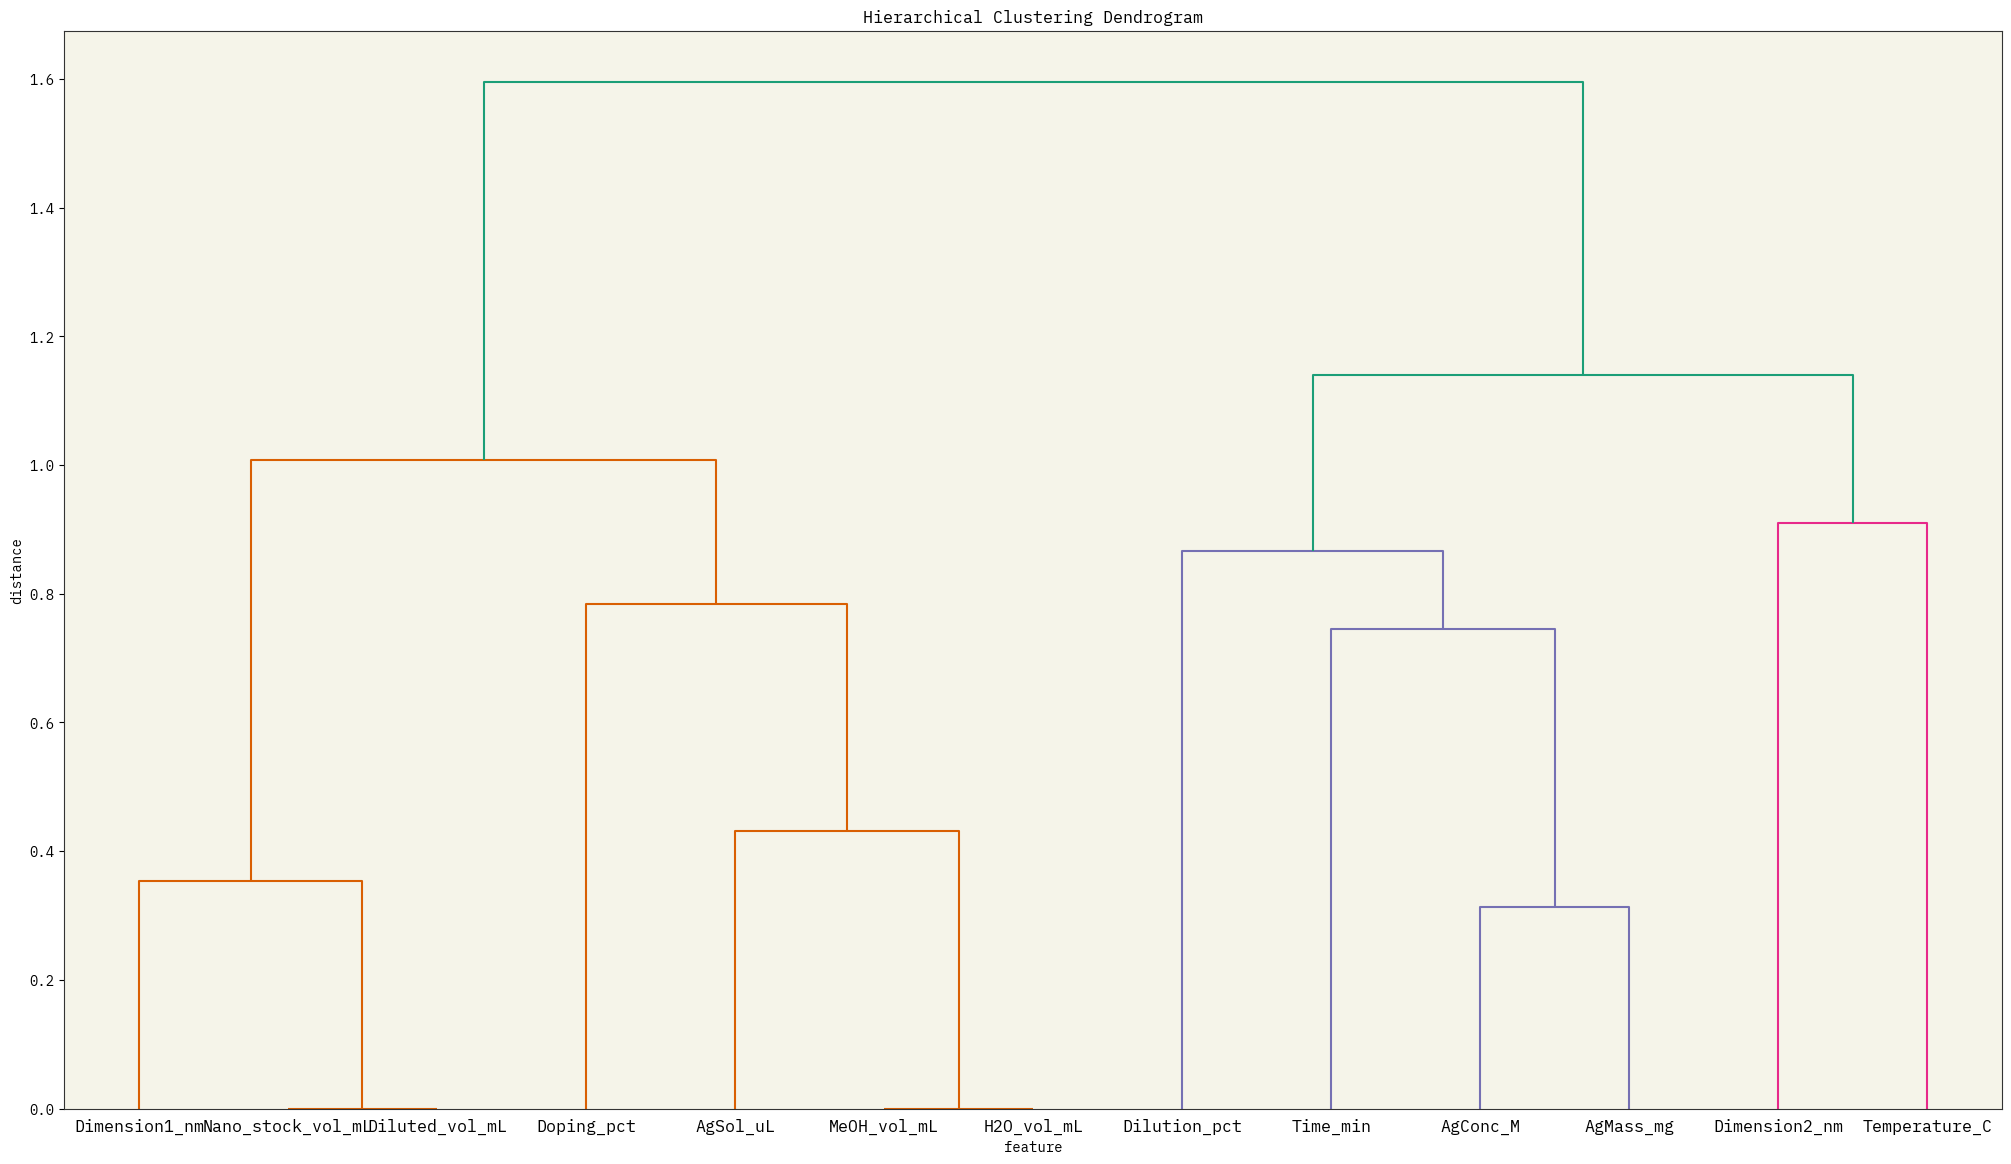

In [25]:
## Following the example from shap documentation: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20California%20Demo.html

partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(25, 14))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")

plt.show()

In [ ]:
feature_names = df.keys()[:-1]
feature_names


Index(['Dimension1_nm', 'Dimension2_nm', 'Dilution_pct', 'Nano_stock_vol_mL',
       'Diluted_vol_mL', 'AgConc_M', 'AgMass_mg', 'MeOH_vol_mL', 'H2O_vol_mL',
       'Doping_pct', 'AgSol_uL', 'Time_min', 'Temperature_C'],
      dtype='object')

### Training our BOLIFT Model

In [ ]:
X.astype(float)

Dimension1_nm  Dimension2_nm  Dilution_pct  Nano_stock_vol_mL  \
0          18.800         14.040         0.175               0.25   
1          18.800         14.040         0.175               0.25   
2          18.800         14.040         0.175               0.25   
3          18.800         14.040         0.175               0.25   
4          18.800         14.040         0.175               0.25   
..            ...            ...           ...                ...   
69         26.437          8.291         0.150               0.50   
70         35.064          8.954         0.300               0.50   
71         26.577          5.418         0.150               0.25   
72         26.437          8.291         0.150               0.50   
73         35.064          8.954         0.300               0.50   

    Diluted_vol_mL  AgConc_M  AgMass_mg  MeOH_vol_mL  H2O_vol_mL  Doping_pct  \
0             1.75    0.0060        7.8        5.000       2.000        1.25   
1             1.75    0.0060        7.8        5.000       2.000        2.50   
2             1.75    0.0060        7.8        5.000       2.000        5.00   
3             1.75    0.0060        7.8        5.000       2.000       10.00   
4             1.75    0.0007        3.5       20.000       8.000        0.25   
..             ...       ...        ...          ...         ...         ...   
69            3.50    0.0060        3.5        2.496       0.999        2.00   
70            3.50    0.0060        3.5        2.496       0.999        5.00   
71            1.75    0.0060       14.0        9.985       3.994        5.00   
72            3.50    0.0060        7.8        5.563       2.225       10.00   
73            3.50    0.0060        7.8        5.563       2.225        2.00   

    AgSol_uL  Time_min  Temperature_C  
0      1.400      60.0           25.0  
1      3.400      60.0           25.0  
2      6.800      60.0           25.0  
3     13.700      60.0           25.0  
4      3.000      60.0           25.0  
..       ...       ...            ...  
69     3.780     180.0            0.0  
70    27.072      60.0           50.0  
71     3.104      60.0            0.0  
72    18.898      10.0           25.0  
73    10.829      60.0           50.0  

[74 rows x 13 columns]

In [ ]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo-instruct",
    selector_k=5,
    temperature=0.7
)
labels_f = df['obj_f'].to_list()
for i,l in enumerate(labels_f):
  p = make_prompt_from_features(df.iloc[i].drop('obj_f'))
  if i <3: 
    print(p)
  asktell.tell(p, float(l))
  

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)


Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 5.0 % Ag doping requires 6.8 uL of silver doping solution, respectively. The reaction was perfo

In [ ]:
#defining a wrapper of our BOLIFT model that: 1) takes a dataframe as input, 2) converts it into a text prompt, 3) queries the BOLIFT model, and 4) returns the model's prediction
import time
def f(x):
    results = []
    for i in range(len(x)):
        # Determine if x is a DataFrame or NumPy array
        if isinstance(x, pd.DataFrame):
            features = x.iloc[i]
        else:
            # x is a NumPy array; create a Series with proper feature names
            features = pd.Series(x[i], index=feature_names)
        
        prompt = make_prompt_from_features(features)
        #with a probability of 0.05 print the prompt, to check if the prompt is being generated correctly
        if np.random.rand() < 0.05:
            print(prompt)
        i = 0
        while i <3:
            try:
                result = asktell.predict(prompt).mean()
                results.append(result)     
                i = 4          
            except Exception as e:
                ### Sometimes internet connection fails, so we need to turn off and on the wifi
                print(f"Exception getting prediction : {e}, retrying attempt {i+1}/3")
                #restarting internert
                print("turning off wifi")
                os.system("networksetup -setairportpower airport off")
                time.sleep(2)
                print("turning on wifi")
                os.system("networksetup -setairportpower airport on")
                time.sleep(15)
                i+=1
    if len(results) != len(x):    
            b = len(results)-len(x)
            results[:-b]
    return np.array(results)

In [ ]:
## Testing the function predicts one value.
f(df.iloc[[50]].drop('obj_f', axis=1))

/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


array([0.28])

In [27]:
#see if there are infinite values in X
np.any(np.isinf(X))

False

In [29]:
masker = shap.maskers.Partition(X, clustering=partition_tree)
masker_explainer = shap.PartitionExplainer(f, masker)

In [30]:
f(X[6:7])

/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


array([0.1])

In [ ]:
lowmid_shap_val = masker_explainer(X[6:7]) 

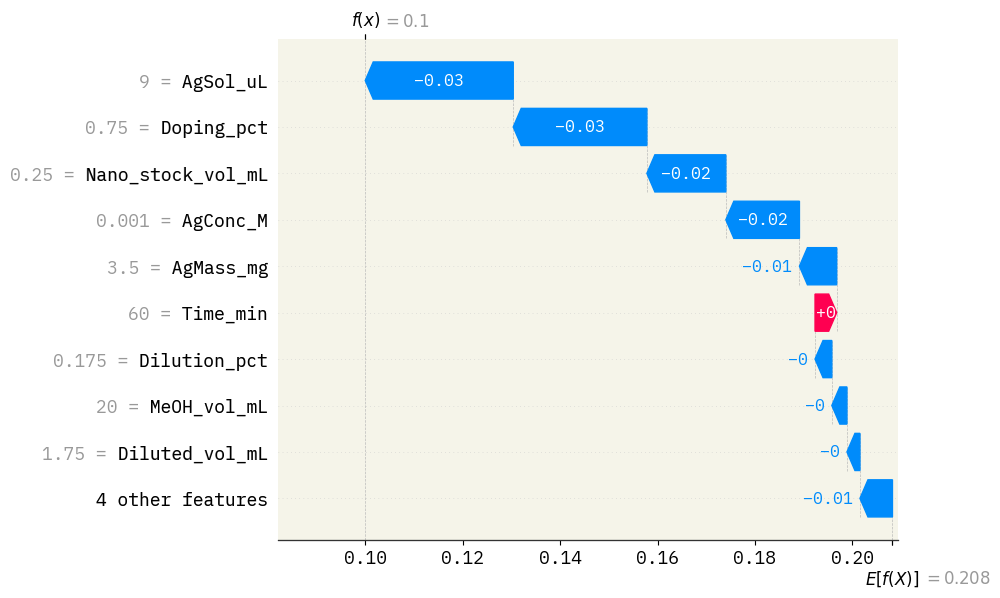

In [75]:
shap.plots.waterfall(lowmid_shap_val[0])

In [ ]:
lowest_shap_val = masker_explainer(X[34:35]) 

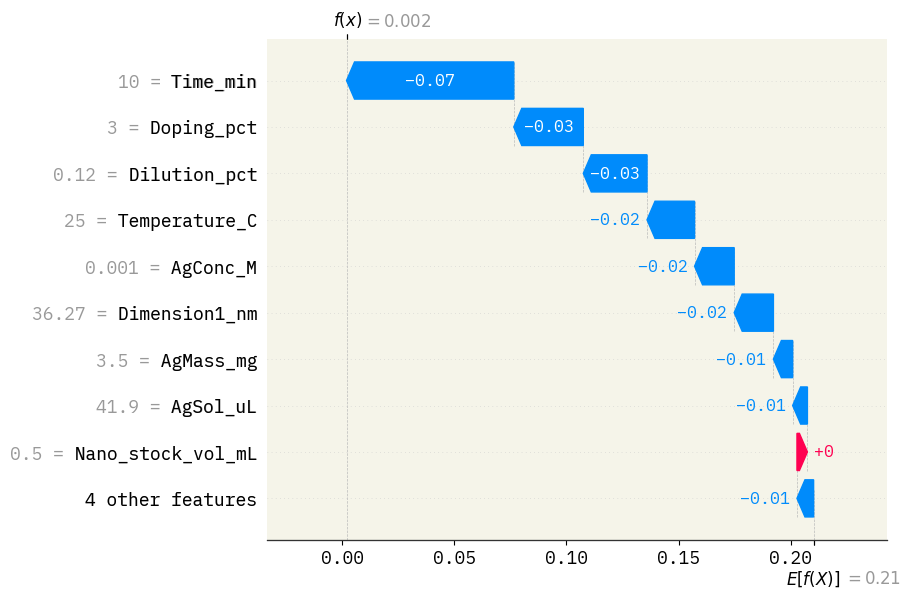

In [77]:
shap.plots.waterfall(lowest_shap_val[0])

In [ ]:
df[63:64]

Dimension1_nm Dimension2_nm Dilution_pct Nano_stock_vol_mL Diluted_vol_mL  \
63      33.65365       6.92590         0.15               0.5            3.5   

   AgConc_M AgMass_mg MeOH_vol_mL H2O_vol_mL Doping_pct AgSol_uL Time_min  \
63    0.006       7.8       5.563      2.225        5.0   10.049       10   

   Temperature_C     obj_f  
63            25  0.782752

In [ ]:
large_shap_val = masker_explainer(X[63:64])

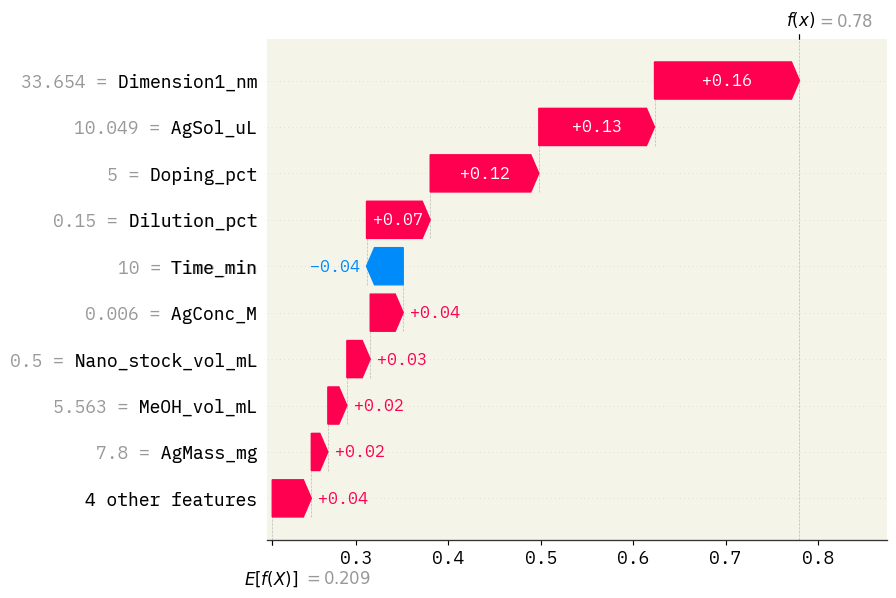

In [43]:
shap.plots.waterfall(large_shap_val[0])

In [ ]:
X[51:52], df.iloc[51]

(   Dimension1_nm Dimension2_nm Dilution_pct Nano_stock_vol_mL Diluted_vol_mL  \
 51       36.9235        7.4427         0.12               0.5            3.5   
 
    AgConc_M AgMass_mg MeOH_vol_mL H2O_vol_mL Doping_pct AgSol_uL Time_min  \
 51  0.00668       7.8           5          2        2.5     4.61       60   
 
    Temperature_C  
 51            25  ,
 Dimension1_nm         36.9235
 Dimension2_nm          7.4427
 Dilution_pct             0.12
 Nano_stock_vol_mL         0.5
 Diluted_vol_mL            3.5
 AgConc_M              0.00668
 AgMass_mg                 7.8
 MeOH_vol_mL                 5
 H2O_vol_mL                  2
 Doping_pct                2.5
 AgSol_uL                 4.61
 Time_min                   60
 Temperature_C              25
 obj_f                0.565383
 Name: 51, dtype: object)

In [ ]:
large_shap_val = masker_explainer(X[51:52])

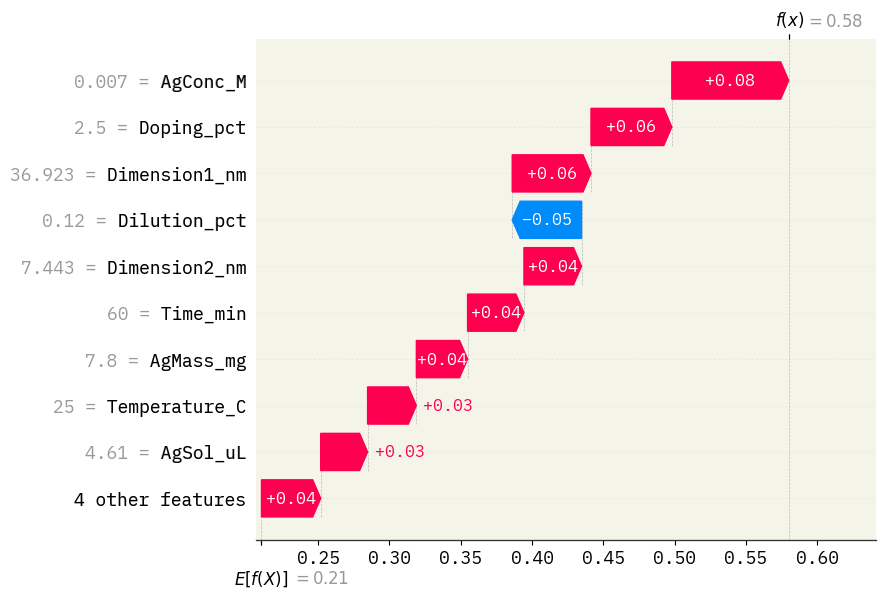

In [ ]:
shap.plots.waterfall(large_shap_val[0])

## LOOCV For BOLIFT with gpt-4o and gpt-3.5 Instruct

100%|██████████| 50/50 [30:57<00:00, 37.14s/it]  

|        predicted        |   label    |     AE     | 
|    0.14   +/-   0.11    |    0.31    |    0.17    |
|    0.13   +/-   0.08    |    0.23    |    0.10    |
|    0.15   +/-   0.03    |    0.23    |    0.09    |
|    0.33   +/-   0.07    |    0.08    |    0.25    |
|    0.06   +/-   0.03    |    0.00    |    0.06    |
|    0.03   +/-   0.01    |    0.09    |    0.06    |
|    0.07   +/-   0.11    |    0.10    |    0.03    |
|    0.15   +/-   0.08    |    0.09    |    0.06    |
|    0.08   +/-   0.07    |    0.09    |    0.01    |
|    0.11   +/-   0.01    |    0.12    |    0.02    |
|    0.11   +/-   0.06    |    0.11    |    0.00    |
|    0.15   +/-   0.02    |    0.10    |    0.04    |
|    0.17   +/-   0.08    |    0.10    |    0.07    |
|    0.06   +/-   0.02    |    0.13    |    0.07    |
|    0.10   +/-   0.01    |    0.12    |    0.02    |
|    0.07   +/-   0.03    |    0.17    |    0.10    |
|    0.26   +/-   0.05    |    0.14    |    0.12    |
|    0.16   +/-   0.08    |

Text(0.5, 1.0, 'f = QY * AUC2')

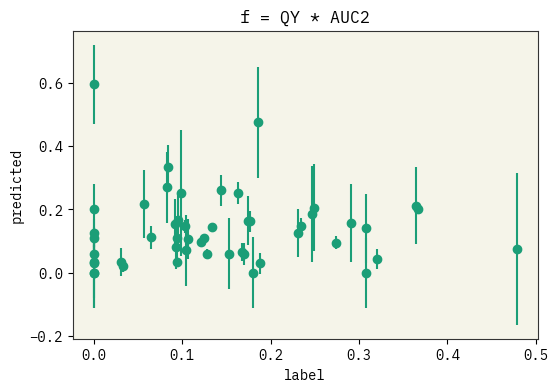

In [269]:
#lets make a LOOCV for the asktell model for the first 50 points

indexes = np.arange(50)
# np.random.shuffle(indexes)
yhat = []
# y_conf = []
y = []
df_for_cv = df_2.iloc[indexes]
prompts = []
labels_f = []
for i, r in df_for_cv.iterrows():
    s = r.drop('obj_f')
    prompts.append(make_prompt_from_features(s))
    labels_f.append(r['obj_f'])

for i in tqdm.tqdm(range(50)):
    train_p = prompts[:i] + prompts[i+1:]
    train_l = labels_f[:i] + labels_f[i+1:]
    test_p = prompts[i]
    test_l = labels_f[i]
    # print(train_p, train_l, test_p, test_l)
    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
            " Each answer should be numeric and ends with ###." \
            " Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo-instruct",
        selector_k=5,
        temperature=0.7
    )
    for i,(p,l) in enumerate(zip(train_p, train_l)):
        # p = make_prompt_from_features(train.iloc[i].drop('obj_f'))
        asktell.tell(p, float(l))

    # for i in range(len(test_p)):
    yhat.append(asktell.predict(test_p))
    y.append(test_l)

#make a plot of the results
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
    n+=1
    mae = abs(ihat.mean()-i)
    print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
    sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
# plt.plot((0,0.2), (0,0.2), '--')



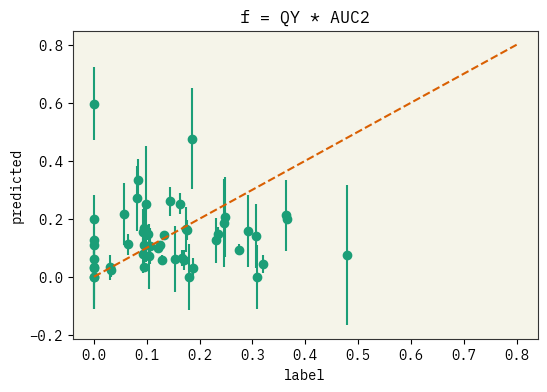

In [270]:
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
plt.plot((0,0.8), (0,0.8), '--')

In [266]:
asktell.predict(test_p)

DiscreteDist([0.01 0.05 0.08], [0.2 0.2 0.6])

In [7]:
import numpy as np
import tqdm
import bolift
indexes = np.arange(50)
# np.random.shuffle(indexes)
yhat = []
# y_conf = []
y = []
df_for_cv = df_2.iloc[indexes]
prompts = []
labels_f = []
for i, r in df_for_cv.iterrows():
    s = r.drop('obj_f')
    prompts.append(make_prompt_from_features(s))
    labels_f.append(r['obj_f'])

for i in tqdm.tqdm(range(50)):
    train_p = prompts[:i] + prompts[i+1:]
    train_l = labels_f[:i] + labels_f[i+1:]
    test_p = prompts[i]
    test_l = labels_f[i]
    # print(train_p, train_l, test_p, test_l)
    asktell = bolift.AskTellFewShotTopk(
        # prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
        #     " Each answer should be numeric and ends with ###." \
        #     " Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )
    for i,(p,l) in enumerate(zip(train_p, train_l)):
        # p = make_prompt_from_features(train.iloc[i].drop('obj_f'))
        asktell.tell(p, float(l))

    # for i in range(len(test_p)):
    yhat.append(asktell.predict(test_p,system_message="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
            " Each answer should be numeric and ends with ###." \
            " Use the following information to complete the prompt: \n"))
    y.append(test_l)

#make a plot of the results
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
    n+=1
    mae = abs(ihat.mean()-i)
    print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
    sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
# plt.plot((0,0.2), (0,0.2), '--')

100%|██████████| 50/50 [31:22<00:00, 37.66s/it]

|        predicted        |   label    |     AE     | 
|    0.08   +/-   0.04    |    0.31    |    0.23    |
|    0.23   +/-   0.04    |    0.23    |    0.00    |
|    0.15   +/-   0.11    |    0.23    |    0.08    |
|    0.11   +/-   0.05    |    0.08    |    0.03    |
|    0.08   +/-   0.11    |    0.00    |    0.08    |
|    0.09   +/-   0.01    |    0.09    |    0.00    |
|    0.07   +/-   0.01    |    0.10    |    0.03    |
|    0.09   +/-   0.01    |    0.09    |    0.01    |
|    0.10   +/-   0.11    |    0.09    |    0.01    |
|    0.10   +/-   0.11    |    0.12    |    0.02    |
|    0.15   +/-   0.00    |    0.11    |    0.04    |
|    0.11   +/-   0.11    |    0.10    |    0.01    |
|    0.15   +/-   0.11    |    0.10    |    0.05    |
|    0.10   +/-   0.00    |    0.13    |    0.03    |
|    0.15   +/-   0.11    |    0.12    |    0.03    |
|    0.13   +/-   0.02    |    0.17    |    0.04    |
|    0.15   +/-   0.00    |    0.14    |    0.01    |
|    0.17   +/-   0.01    |

ModuleNotFoundError: No module named 'matplotlib'

In [28]:
## Wrapping the code:
def loocv_asktell(df_2, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=0):
    indexes = np.arange(60)
    yhat = []
    y = []
    df_for_cv = df_2.iloc[indexes]
    prompts = []
    labels_f = []
    
    for i, r in df_for_cv.iterrows():
        s = r.drop('obj_f')
        prompts.append(make_prompt_from_features(s,version=prompt_version))
        labels_f.append(r['obj_f'])

    for i in tqdm.tqdm(range(60)):
        train_p = prompts[:i] + prompts[i+1:]
        train_l = labels_f[:i] + labels_f[i+1:]
        test_p = prompts[i]
        test_l = labels_f[i]

        asktell = bolift.AskTellFewShotTopk(
            # prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
            #        " Each answer should be numeric and ends with ###." \
            #        " Use the following information to complete the prompt: \n",
            x_formatter=lambda x: f"the experimental procedure: {x}",
            y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
            y_formatter=lambda y: f"{y:.2f}",
            model=model,
            selector_k=selector_k,
            temperature=temperature
        )
        
        for p, l in zip(train_p, train_l):
            asktell.tell(p, float(l))

        yhat.append(asktell.predict(test_p))
        y.append(test_l)

    # Plot results and calculate RMSE
    def rmse(a, b):
        a = np.array(a)
        b = np.array(b)
        return np.sqrt(np.mean((a - b)**2))

    print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
    sum = 0
    for ihat, i in zip(yhat, y):
        mae = abs(ihat.mean() - i)
        print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
        sum += mae
    print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

    y_plot = np.array(y)[np.where(np.array(y) >= 0)]
    yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
    yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('label')
    plt.ylabel('predicted')
    plt.plot(y_plot, yhat_plot, 'o')
    plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
    plt.title('f = QY * AUC2')
    plt.show()

In [74]:
def cv_asktell(df_2, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=0):

    #randomly shuffle the dataset
    indexes = np.arange(len(df_2))
    np.random.shuffle(indexes)
    #split the dataset into 5 folds

    df_for_cv = df_2.iloc[indexes]
    folds = np.array_split(indexes, 5)

    prompts = []
    labels_f = []
    
    # 2. Create all prompts/labels in order; 
    #    the position in 'prompts'/'labels_f' corresponds to 'df_for_cv' row order.
    for _, r in df_for_cv.iterrows():
        s = r.drop('obj_f')  # all features except the target
        prompts.append(make_prompt_from_features(s, version=prompt_version))
        labels_f.append(r['obj_f'])

    # We'll accumulate predictions (yhat) and true labels (y) across all folds
    yhat = []
    std_hat = []
    y = []
    rmses = []
    retries = []
    # 3. Loop over each of the 5 folds
    for fold_idx in tqdm.tqdm(range(5)):
        # 4. Assign test fold and train folds
        test_indexes = folds[fold_idx]
        train_indexes = np.concatenate([folds[i] for i in range(5) if i != fold_idx])

        # 5. Create train/test sets for prompts and labels
        train_p = [prompts[i] for i in train_indexes]
        train_l = [labels_f[i] for i in train_indexes]
        test_p  = [prompts[i] for i in test_indexes]
        test_l  = [labels_f[i] for i in test_indexes]

        # 6. Create the AskTellFewShotTopk object for this fold
        asktell = bolift.AskTellFewShotTopk(
            x_formatter=lambda x: f"the experimental procedure: {x}",
            y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
            y_formatter=lambda y: f"{y:.2f}",
            model=model,
            selector_k=selector_k,
            temperature=temperature
        )

        # 7. "Tell" the model about each of the training samples
        for p, l in zip(train_p, train_l):
            asktell.tell(p, float(l))

        # 8. Predict on the test fold and store results
        _yhat = []
        _yreal = []
        _std_hat = []
        _retries = []
        for p, r in zip(test_p, test_l):
            n_retries = 0
            flag = True
            while flag :
                pred = asktell.predict(p)
                if pred.mean() > 1:
                    print("Prediction is greater than 1, retrying")
                    n_retries += 1
                else:
                    flag = False
                if n_retries > 10:
                    print("Too many retries, breaking")
                    break
            if n_retries <=10:
                _yhat.append(pred.mean())
                _std_hat.append(pred.std())
                _retries.append(n_retries)
                _yreal.append(r)
        y.append(_yreal)  # true labels for the test fold
        yhat.append(_yhat)  # predictions for the test fold
        std_hat.append(_std_hat)  # std. dev. for the test fold
        print("Fold", fold_idx, "done")
        #plot results and calculate RMSE
        def rmse(a, b):
            a = np.array(a)
            b = np.array(b)
            return np.sqrt(np.mean((a - b)**2))
        
        print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
        sum = 0
        for ihat, i in zip(_yhat, _yreal):
            mae = abs(ihat - i)
            print(f"| {ihat:^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
            sum += mae
        print(f"\n{'RMSE: ':>20s}{rmse(_yhat, _yreal):<18.2f}")
        rmses.append(rmse(_yhat, _yreal))    
        retries.append(_retries)
        y_plot = np.array(_yreal)[np.where(np.array(_yreal) >= 0)]
        yhat_plot = np.array(_yhat)[np.where(np.array(_yreal) >= 0)]
        yerr_plot = np.array(_std_hat)[np.where(np.array(_yreal) >= 0)]
        plt.figure(figsize=(6, 4))
        plt.xlabel('label')
        plt.ylabel('predicted')
        plt.plot(y_plot, yhat_plot, 'o')
        plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
        plt.title(f'f = QY * AUC2| {model} |Fold: '+str(fold_idx+1) + " | Total Retries "+str((np.sum(retries[-1])))) #include the number of retries of the model
        #include the number of retries of the model

        #add a line to show the perfect prediction
        plt.plot((0,1), (0,1), '--')

        plt.show()

    #plot all folds together in 5 subplots|
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

    for i, (y_1, yhat_1, rmses, ax,retries) in enumerate(zip(y, yhat, rmses, axs,retries)):
        print(f"Run {i}: {np.mean(rmses):.2f} +/- {np.std(rmses):.2f}")
        
        ax.set_title(f"Fold {i+1}\nRMSE: {np.mean(rmses):.2f}")
        sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=ax, color='C0')
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="gray")
        ax.errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
        #include correlation coefficient
        ax.text(0.05, 0.95, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=ax.transAxes)
        ax.text(0.05, 0.85, f"RMSE: {np.mean(rmses):.2f}", transform=ax.transAxes)
        ax.text(0.05, 0.75, f"Retries: {np.sum(retries)}", transform=ax.transAxes)
        ax.set_xlabel("True value")
        ax.set_ylabel("Predicted value")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    #set supertitle
    plt.suptitle("5 Fold Cross Validation Results | Prompt Version "+str(prompt_version))
    plt.tight_layout()
    plt.show()
    

    return yhat,std_hat, y

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.07    |    0.37    |    0.29    |
|    0.07    |    0.18    |    0.10    |
|    0.42    |    0.32    |    0.10    |
|    0.18    |    0.17    |    0.01    |
|    0.15    |    0.14    |    0.01    |
|    0.20    |    0.16    |    0.04    |
|    0.09    |    0.19    |    0.09    |
|    0.11    |    0.09    |    0.02    |
|    0.00    |    0.08    |    0.08    |
|    0.09    |    0.06    |    0.03    |
|    0.05    |    0.03    |    0.02    |
|    0.18    |    0.17    |    0.01    |
|    0.13    |    0.00    |    0.13    |
|    0.28    |    0.13    |    0.15    |
|    0.14    |    0.27    |    0.13    |

              RMSE: 0.11              


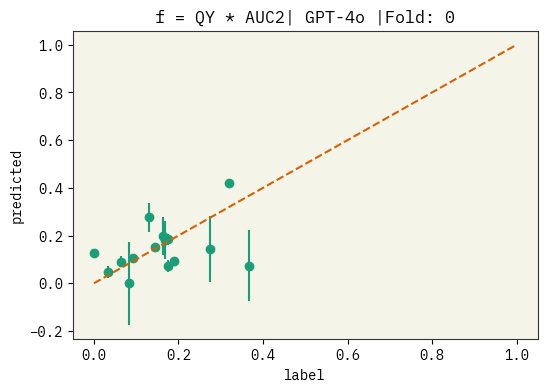

 20%|██        | 1/5 [00:51<03:27, 51.87s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.19    |    0.31    |    0.12    |
|    0.15    |    0.17    |    0.02    |
|    0.08    |    0.00    |    0.08    |
|    0.19    |    0.65    |    0.46    |
|    0.18    |    0.58    |    0.40    |
|    0.40    |    0.33    |    0.07    |
|    0.35    |    0.00    |    0.35    |
|    0.11    |    0.12    |    0.01    |
|    0.14    |    0.52    |    0.38    |
|    0.12    |    0.11    |    0.01    |
|    0.22    |    0.06    |    0.16    |
|    0.35    |    0.78    |    0.43    |
|    0.12    |    0.17    |    0.05    |
|    0.11    |    0.28    |    0.17    |
|    0.25    |    0.36    |    0.12    |

              RMSE: 0.25              


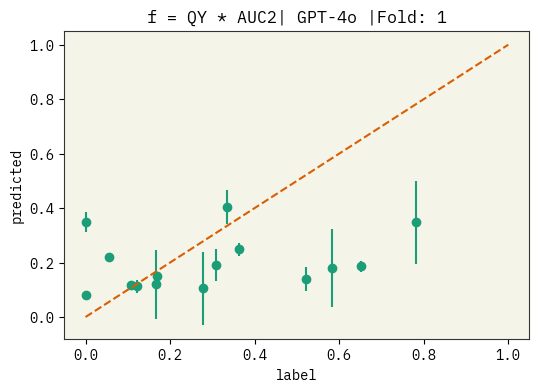

 40%|████      | 2/5 [01:44<02:37, 52.44s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.06    |    0.09    |    0.03    |
|    0.47    |    0.26    |    0.21    |
|    0.03    |    0.18    |    0.15    |
|    0.01    |    0.00    |    0.01    |
|    0.17    |    0.13    |    0.04    |
|    0.63    |    0.18    |    0.45    |
|    0.31    |    0.29    |    0.01    |
|    0.07    |    0.17    |    0.11    |
|    0.21    |    0.13    |    0.08    |
|    0.01    |    0.03    |    0.02    |
|    0.01    |    0.00    |    0.01    |
|    0.01    |    0.15    |    0.15    |
|    0.11    |    0.20    |    0.08    |
|    0.11    |    0.10    |    0.02    |
|    0.35    |    0.14    |    0.20    |

              RMSE: 0.16              


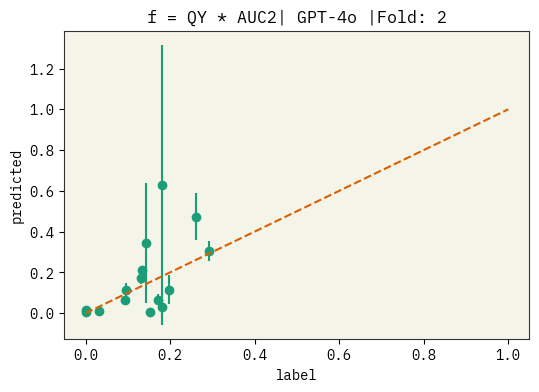

 60%|██████    | 3/5 [02:51<01:58, 59.01s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.12    |    0.08    |    0.03    |
|    0.10    |    0.31    |    0.21    |
|    0.00    |    0.00    |    0.00    |
|    0.05    |    0.09    |    0.04    |
|    0.18    |    0.23    |    0.05    |
|    0.35    |    0.00    |    0.35    |
|    0.12    |    0.25    |    0.12    |
|    0.20    |    0.19    |    0.02    |
|    0.25    |    0.04    |    0.21    |
|    0.10    |    0.12    |    0.02    |
|    0.32    |    0.49    |    0.17    |
|    0.00    |    0.00    |    0.00    |
|    0.27    |    0.28    |    0.02    |
|    0.58    |    0.33    |    0.26    |
|    0.09    |    0.10    |    0.02    |

              RMSE: 0.15              


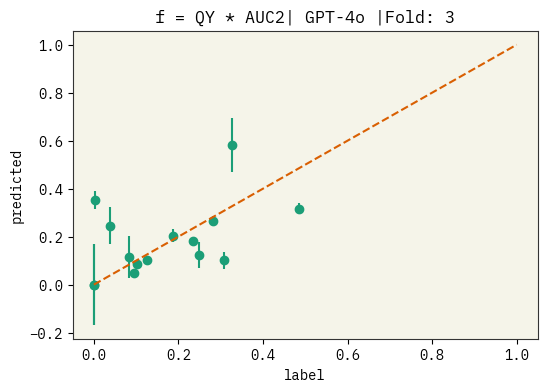

 80%|████████  | 4/5 [03:47<00:57, 57.84s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.09    |    0.10    |    0.01    |
|    0.10    |    0.13    |    0.03    |
|    0.12    |    0.17    |    0.04    |
|    0.49    |    0.36    |    0.13    |
|    0.48    |    0.44    |    0.04    |
|    0.25    |    0.27    |    0.02    |
|    0.12    |    0.25    |    0.12    |
|    0.23    |    0.23    |    0.00    |
|    0.00    |    0.00    |    0.00    |
|    0.09    |    0.09    |    0.01    |
|    0.31    |    0.42    |    0.11    |
|    0.38    |    0.35    |    0.03    |
|    0.50    |    0.54    |    0.04    |
|    0.17    |    0.10    |    0.08    |

              RMSE: 0.06              


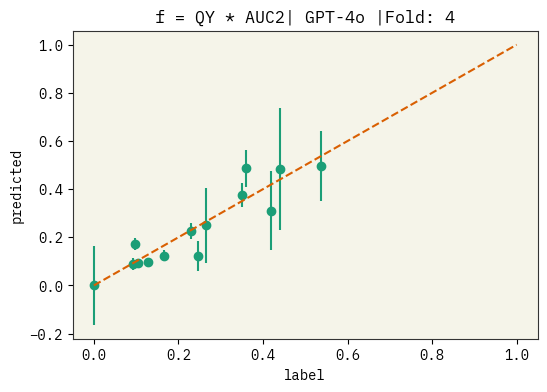

100%|██████████| 5/5 [04:29<00:00, 53.99s/it]

Run 0: 0.11 +/- 0.00
Run 1: 0.25 +/- 0.00
Run 2: 0.16 +/- 0.00
Run 3: 0.15 +/- 0.00
Run 4: 0.06 +/- 0.00


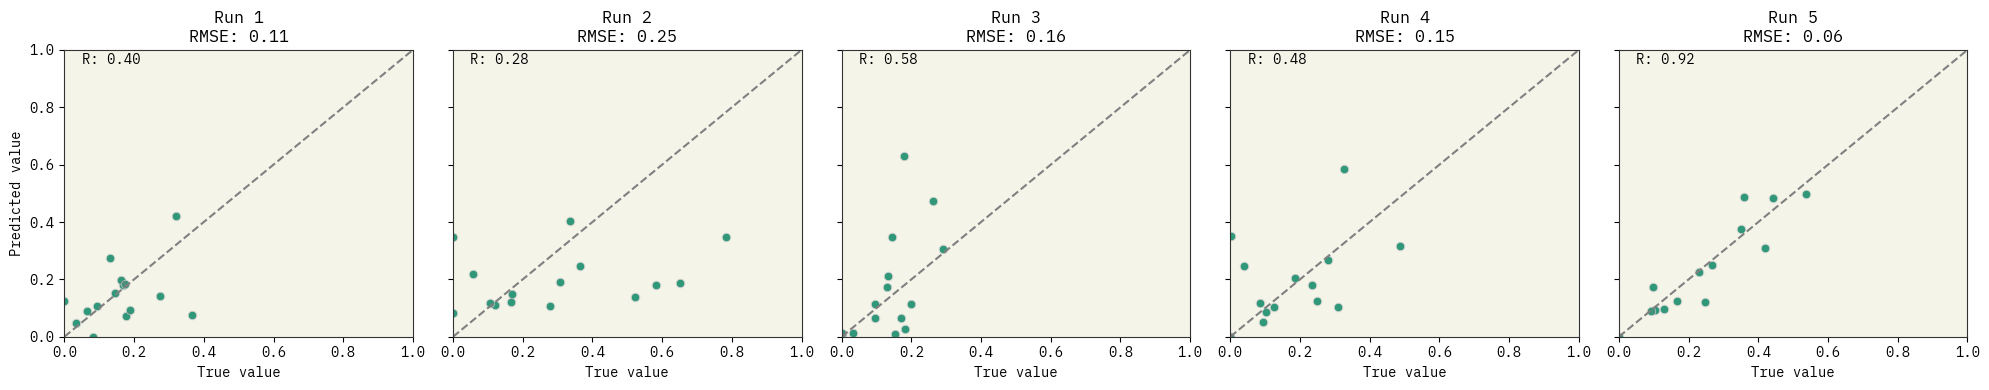

In [ ]:
yhat,std_hat,y= cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=0)

  0%|          | 0/60 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
  2

|        predicted        |   label    |     AE     | 
|    0.02   +/-   0.01    |    0.31    |    0.29    |
|    0.21   +/-   0.07    |    0.23    |    0.02    |
|    0.18   +/-   0.02    |    0.23    |    0.06    |
|    0.22   +/-   0.04    |    0.08    |    0.14    |
|    0.08   +/-   0.00    |    0.00    |    0.08    |
|    0.06   +/-   0.13    |    0.09    |    0.03    |
|    0.07   +/-   0.00    |    0.10    |    0.03    |
|    0.09   +/-   0.13    |    0.09    |    0.00    |
|    0.11   +/-   0.00    |    0.09    |    0.02    |
|    0.11   +/-   0.00    |    0.12    |    0.02    |
|    0.14   +/-   0.00    |    0.11    |    0.03    |
|    0.10   +/-   0.02    |    0.10    |    0.01    |
|    0.09   +/-   0.01    |    0.10    |    0.00    |
|    0.15   +/-   0.03    |    0.13    |    0.02    |
|    0.00   +/-   0.00    |    0.12    |    0.12    |
|    0.14   +/-   0.01    |    0.17    |    0.03    |
|    0.16   +/-   0.00    |    0.14    |    0.02    |
|    0.14   +/-   0.02    |

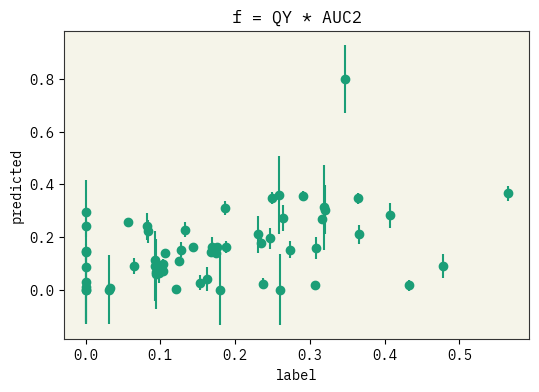

In [ ]:
#test version 0
loocv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=1)

  0%|          | 0/60 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
  2

|        predicted        |   label    |     AE     | 
|    0.01   +/-   0.01    |    0.31    |    0.29    |
|    0.17   +/-   0.06    |    0.23    |    0.06    |
|    0.17   +/-   0.02    |    0.23    |    0.06    |
|    0.20   +/-   0.04    |    0.08    |    0.11    |
|    0.08   +/-   0.00    |    0.00    |    0.08    |
|    0.06   +/-   0.13    |    0.09    |    0.03    |
|    0.07   +/-   0.00    |    0.10    |    0.03    |
|    0.09   +/-   0.00    |    0.09    |    0.00    |
|    0.12   +/-   0.00    |    0.09    |    0.02    |
|    0.11   +/-   0.00    |    0.12    |    0.02    |
|    0.14   +/-   0.00    |    0.11    |    0.03    |
|    0.10   +/-   0.02    |    0.10    |    0.01    |
|    0.10   +/-   0.02    |    0.10    |    0.00    |
|    0.14   +/-   0.04    |    0.13    |    0.01    |
|    0.16   +/-   0.13    |    0.12    |    0.04    |
|    0.12   +/-   0.00    |    0.17    |    0.04    |
|    0.16   +/-   0.00    |    0.14    |    0.02    |
|    0.14   +/-   0.02    |

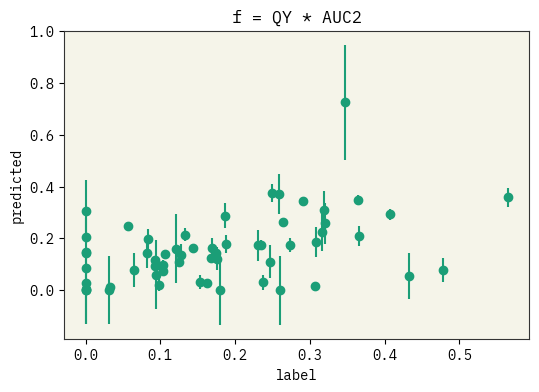

In [ ]:
loocv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=2)

  0%|          | 0/60 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
  2

|        predicted        |   label    |     AE     | 
|    0.12   +/-   0.07    |    0.31    |    0.19    |
|    0.05   +/-   0.03    |    0.23    |    0.18    |
|    0.09   +/-   0.05    |    0.23    |    0.15    |
|    0.27   +/-   0.02    |    0.08    |    0.19    |
|    0.08   +/-   0.00    |    0.00    |    0.08    |
|    0.08   +/-   0.00    |    0.09    |    0.02    |
|    0.09   +/-   0.00    |    0.10    |    0.02    |
|    0.08   +/-   0.13    |    0.09    |    0.01    |
|    0.10   +/-   0.00    |    0.09    |    0.01    |
|    0.09   +/-   0.00    |    0.12    |    0.03    |
|    0.13   +/-   0.01    |    0.11    |    0.02    |
|    0.11   +/-   0.01    |    0.10    |    0.01    |
|    0.10   +/-   0.01    |    0.10    |    0.00    |
|    0.10   +/-   0.01    |    0.13    |    0.03    |
|    0.03   +/-   0.04    |    0.12    |    0.09    |
|    0.11   +/-   0.02    |    0.17    |    0.06    |
|    0.17   +/-   0.01    |    0.14    |    0.02    |
|    0.19   +/-   0.00    |

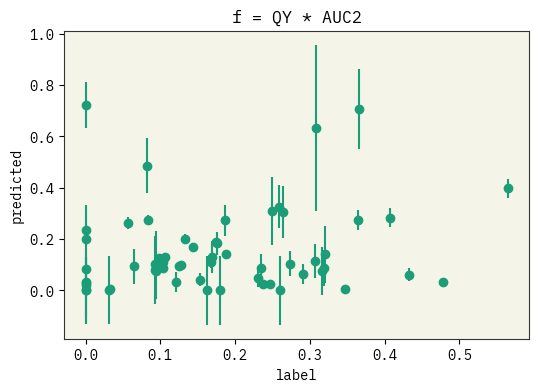

In [ ]:
loocv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=3)

  0%|          | 0/60 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
  2

|        predicted        |   label    |     AE     | 
|    0.23   +/-   0.13    |    0.31    |    0.08    |
|    0.26   +/-   0.04    |    0.23    |    0.03    |
|    0.25   +/-   0.03    |    0.23    |    0.01    |
|    0.23   +/-   0.13    |    0.08    |    0.15    |
|    0.09   +/-   0.00    |    0.00    |    0.09    |
|    0.10   +/-   0.13    |    0.09    |    0.01    |
|    0.09   +/-   0.13    |    0.10    |    0.01    |
|    0.10   +/-   0.00    |    0.09    |    0.01    |
|    0.10   +/-   0.00    |    0.09    |    0.00    |
|    0.09   +/-   0.13    |    0.12    |    0.03    |
|    0.10   +/-   0.13    |    0.11    |    0.01    |
|    0.09   +/-   0.13    |    0.10    |    0.01    |
|    0.09   +/-   0.13    |    0.10    |    0.01    |
|    0.17   +/-   0.13    |    0.13    |    0.04    |
|    0.17   +/-   0.13    |    0.12    |    0.05    |
|    0.15   +/-   0.02    |    0.17    |    0.02    |
|    0.17   +/-   0.13    |    0.14    |    0.03    |
|    0.15   +/-   0.02    |

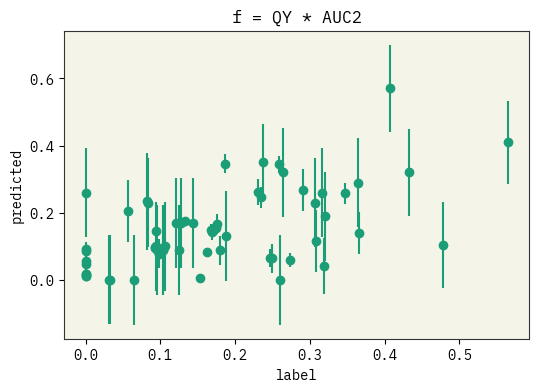

In [ ]:
loocv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=4)

  0%|          | 0/60 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
  2

|        predicted        |   label    |     AE     | 
|    0.02   +/-   0.01    |    0.31    |    0.29    |
|    0.33   +/-   0.02    |    0.23    |    0.10    |
|    0.18   +/-   0.02    |    0.23    |    0.05    |
|    0.27   +/-   0.05    |    0.08    |    0.18    |
|    0.07   +/-   0.02    |    0.00    |    0.07    |
|    0.08   +/-   0.00    |    0.09    |    0.01    |
|    0.08   +/-   0.13    |    0.10    |    0.02    |
|    0.10   +/-   0.02    |    0.09    |    0.00    |
|    0.08   +/-   0.00    |    0.09    |    0.01    |
|    0.09   +/-   0.13    |    0.12    |    0.03    |
|    0.13   +/-   0.01    |    0.11    |    0.03    |
|    0.09   +/-   0.02    |    0.10    |    0.02    |
|    0.08   +/-   0.01    |    0.10    |    0.02    |
|    0.03   +/-   0.03    |    0.13    |    0.10    |
|    0.15   +/-   0.01    |    0.12    |    0.03    |
|    0.15   +/-   0.13    |    0.17    |    0.02    |
|    0.15   +/-   0.01    |    0.14    |    0.01    |
|    0.09   +/-   0.01    |

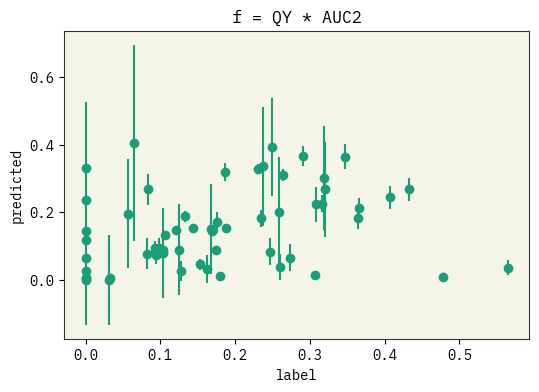

In [ ]:
loocv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=5)

In [ ]:
yhat_1,std_hat_1,y_1= cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=1)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.16    |    0.31    |    0.15    |
|    0.26    |    0.65    |    0.39    |
|   390.23   |    0.27    |   389.96   |
|    0.02    |    0.03    |    0.01    |
|    0.12    |    0.11    |    0.01    |
|    0.00    |    0.28    |    0.28    |
|    0.16    |    0.10    |    0.06    |
|    0.17    |    0.23    |    0.06    |
|    0.08    |    0.10    |    0.02    |
|    0.24    |    0.58    |    0.34    |
|    0.16    |    0.14    |    0.01    |
|    0.31    |    0.31    |    0.00    |
|    0.24    |    0.13    |    0.11    |
|    0.22    |    0.78    |    0.56    |
|    0.26    |    0.54    |    0.28    |

              RMSE: 100.69            


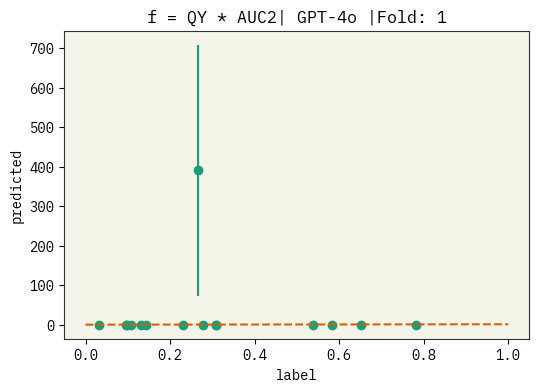

 20%|██        | 1/5 [01:02<04:09, 62.32s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 1 done
|        predicted        |   label    |     AE     | 
|   260.41   |    0.36    |   260.05   |
|    0.38    |    0.32    |    0.06    |
|    0.11    |    0.09    |    0.02    |
|    0.00    |    0.18    |    0.18    |
|    0.02    |    0.15    |    0.13    |
|    0.09    |    0.10    |    0.01    |
|   130.00   |    0.52    |   129.48   |
|    0.29    |    0.06    |    0.24    |
|    0.44    |    0.49    |    0.05    |
|    0.18    |    0.13    |    0.05    |
|    0.22    |    0.19    |    0.04    |
|    0.63    |    0.26    |    0.37    |
|   520.06   |    0.35    |   519.71   |
|    0.32    |    0.37    |    0.05    |
|    0.51    |    0.28    |    0.22    |

              RMSE: 153.73            


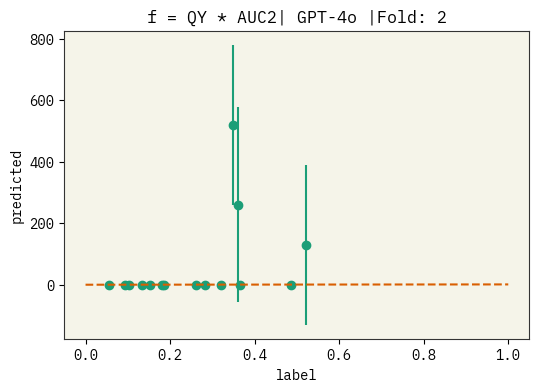

 40%|████      | 2/5 [02:08<03:13, 64.55s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.11    |    0.17    |    0.07    |
|    0.14    |    0.19    |    0.04    |
|   390.02   |    0.03    |   389.99   |
|    0.04    |    0.17    |    0.13    |
|    0.01    |    0.00    |    0.01    |
|    0.17    |    0.33    |    0.16    |
|    0.13    |    0.25    |    0.12    |
|    0.50    |    0.44    |    0.06    |
|    0.41    |    0.00    |    0.41    |
|    0.30    |    0.33    |    0.03    |
|    0.09    |    0.17    |    0.08    |
|    0.05    |    0.09    |    0.05    |
|    0.07    |    0.20    |    0.13    |
|    0.09    |    0.18    |    0.09    |
|    0.06    |    0.10    |    0.04    |

              RMSE: 100.69            


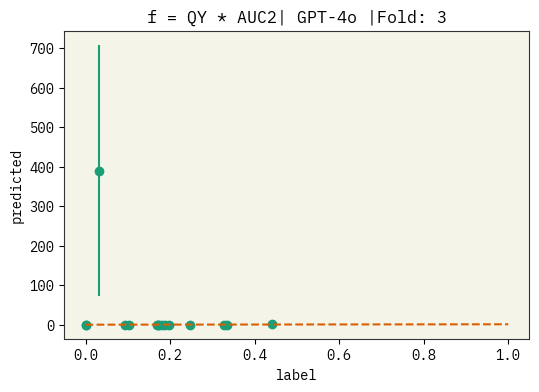

 60%|██████    | 3/5 [03:01<01:58, 59.08s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.17    |    0.23    |    0.06    |
|    0.07    |    0.09    |    0.03    |
|    0.10    |    0.13    |    0.03    |
|    0.00    |    0.00    |    0.00    |
|    0.00    |    0.00    |    0.00    |
|   390.26   |    0.42    |   389.84   |
|   130.09   |    0.13    |   129.96   |
|   130.05   |    0.08    |   129.97   |
|    0.35    |    0.25    |    0.10    |
|    0.17    |    0.00    |    0.17    |
|   390.40   |    0.17    |   390.23   |
|    0.12    |    0.18    |    0.06    |
|   130.06   |    0.09    |   129.97   |
|    0.11    |    0.17    |    0.05    |
|    0.11    |    0.14    |    0.03    |

              RMSE: 153.83            


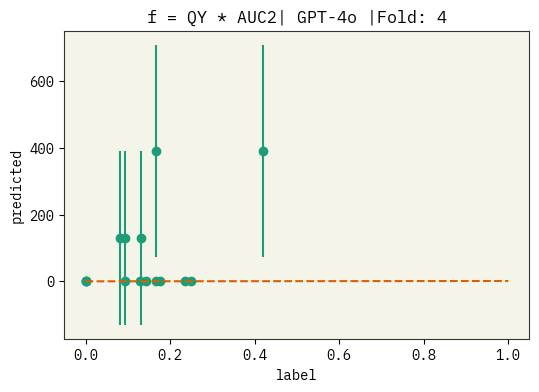

 80%|████████  | 4/5 [04:28<01:10, 70.16s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.04    |    0.10    |
|    0.17    |    0.00    |    0.17    |
|    0.34    |    0.00    |    0.34    |
|    0.10    |    0.12    |    0.02    |
|    0.08    |    0.00    |    0.08    |
|    0.12    |    0.06    |    0.06    |
|    0.15    |    0.12    |    0.03    |
|   130.20   |    0.29    |   129.91   |
|   130.14   |    0.08    |   130.06   |
|    0.21    |    0.17    |    0.04    |
|   130.16   |    0.27    |   129.89   |
|    0.02    |    0.00    |    0.02    |
|    0.14    |    0.16    |    0.02    |
|    0.27    |    0.36    |    0.09    |

              RMSE: 60.16             


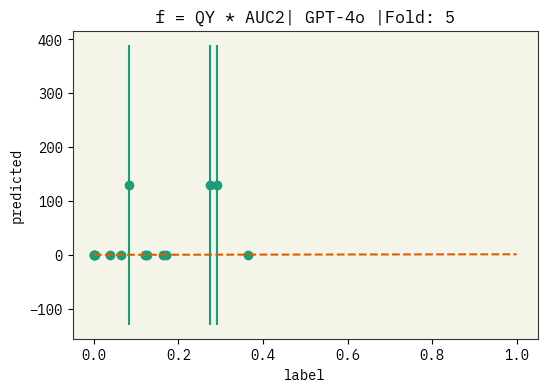

100%|██████████| 5/5 [05:38<00:00, 67.78s/it]

Run 0: 100.69 +/- 0.00
Run 1: 153.73 +/- 0.00
Run 2: 100.69 +/- 0.00
Run 3: 153.83 +/- 0.00
Run 4: 60.16 +/- 0.00


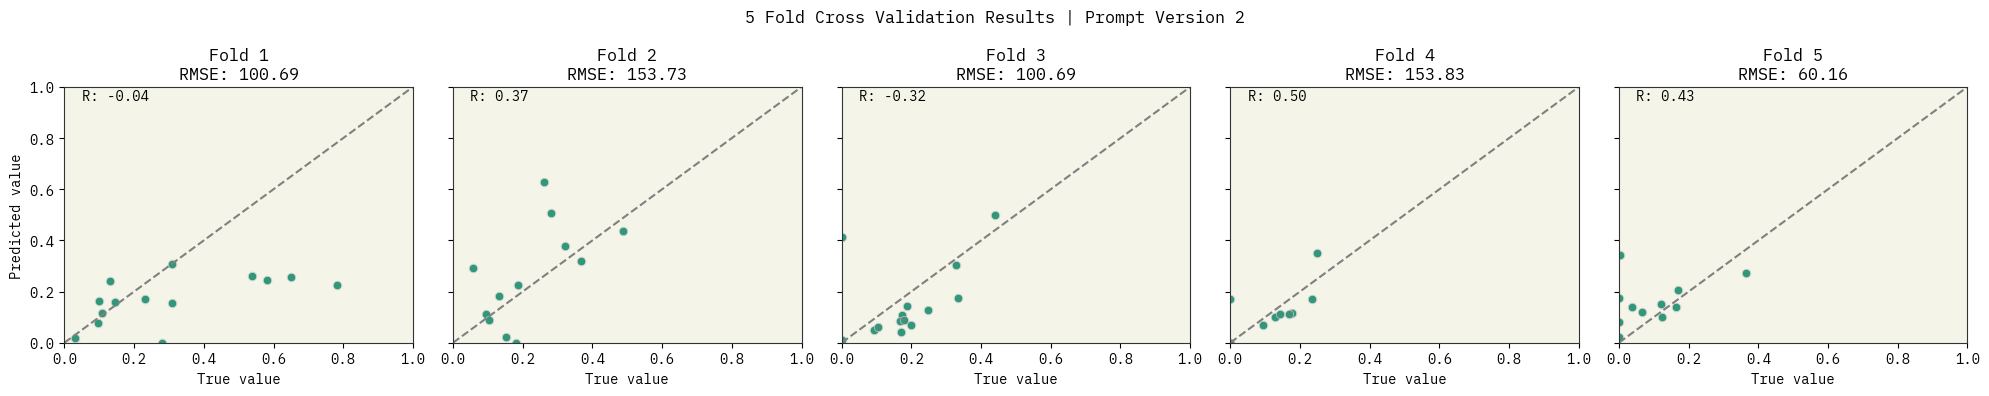

In [ ]:
yhat_2,std_hat_2,y_2= cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=2)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.02    |    0.00    |    0.02    |
|    0.15    |    0.14    |    0.01    |
|    0.21    |    0.04    |    0.18    |
|    0.13    |    0.20    |    0.07    |
|    0.34    |    0.00    |    0.34    |
|    0.29    |    0.28    |    0.01    |
|    0.02    |    0.00    |    0.02    |
|    0.21    |    0.31    |    0.10    |
|    0.15    |    0.17    |    0.02    |
|    0.37    |    0.49    |    0.11    |
|    0.12    |    0.17    |    0.04    |
|    0.08    |    0.09    |    0.01    |
|    0.24    |    0.10    |    0.15    |
|    0.11    |    0.06    |    0.04    |
|    0.08    |    0.00    |    0.08    |

              RMSE: 0.12              


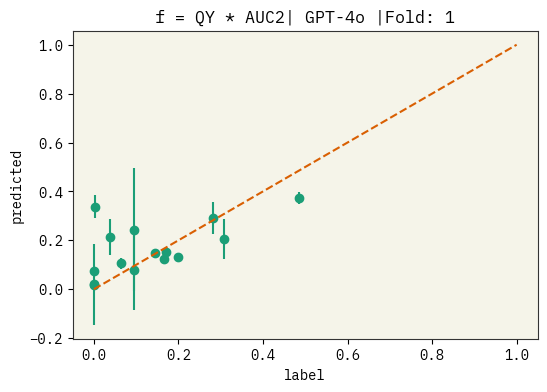

 20%|██        | 1/5 [01:04<04:18, 64.57s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.09    |    0.09    |    0.01    |
|    0.20    |    0.00    |    0.20    |
|    0.31    |    0.54    |    0.23    |
|    0.18    |    0.16    |    0.01    |
|    0.01    |    0.15    |    0.14    |
|    0.04    |    0.08    |    0.04    |
|    0.20    |    0.17    |    0.03    |
|    0.17    |    0.17    |    0.00    |
|    0.22    |    0.33    |    0.11    |
|    0.43    |    0.78    |    0.35    |
|    0.05    |    0.28    |    0.23    |
|    0.10    |    0.09    |    0.00    |
|    0.16    |    0.00    |    0.16    |
|    0.21    |    0.25    |    0.04    |
|    0.13    |    0.10    |    0.03    |

              RMSE: 0.15              


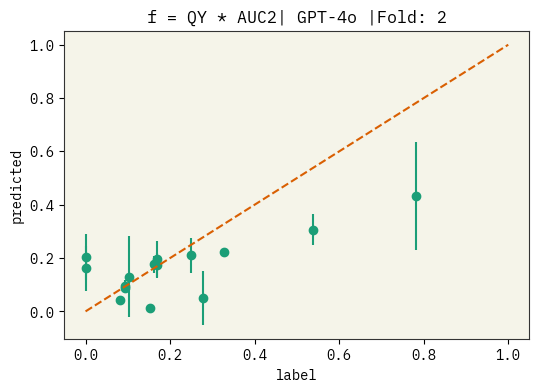

 40%|████      | 2/5 [02:00<02:57, 59.29s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.13    |    0.52    |    0.39    |
|    0.34    |    0.27    |    0.06    |
|    0.06    |    0.09    |    0.04    |
|    0.09    |    0.10    |    0.01    |
|    0.21    |    0.13    |    0.07    |
|    0.23    |    0.18    |    0.05    |
|    0.09    |    0.31    |    0.22    |
|    0.00    |    0.18    |    0.18    |
|    0.21    |    0.18    |    0.03    |
|    0.12    |    0.12    |    0.01    |
|    0.35    |    0.10    |    0.25    |
|    0.15    |    0.17    |    0.01    |
|    0.28    |    0.35    |    0.07    |
|    0.14    |    0.06    |    0.09    |
|    0.48    |    0.44    |    0.04    |

              RMSE: 0.15              


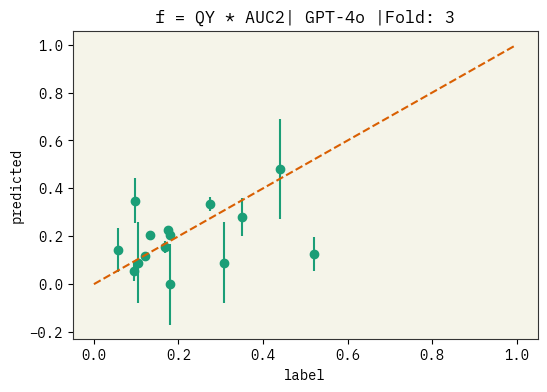

 60%|██████    | 3/5 [02:51<01:51, 55.87s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.03    |    0.03    |    0.00    |
|    0.53    |    0.58    |    0.05    |
|    0.00    |    0.36    |    0.36    |
|   130.30   |    0.00    |   130.30   |
|    0.18    |    0.13    |    0.05    |
|    0.36    |    0.37    |    0.00    |
|    0.12    |    0.14    |    0.02    |
|    0.10    |    0.13    |    0.03    |
|    0.24    |    0.19    |    0.06    |
|    0.00    |    0.03    |    0.03    |
|    0.25    |    0.23    |    0.02    |
|    0.17    |    0.13    |    0.04    |
|    0.26    |    0.29    |    0.03    |
|    0.15    |    0.19    |    0.04    |
|    0.26    |    0.36    |    0.11    |

              RMSE: 33.64             


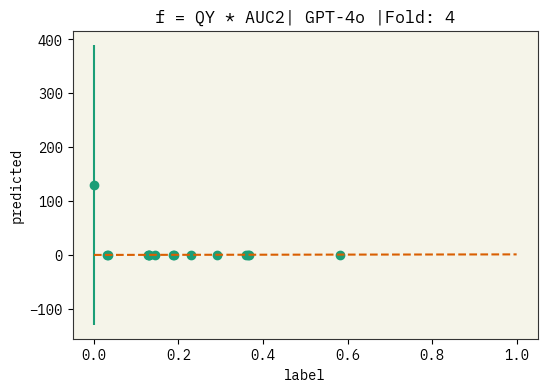

 80%|████████  | 4/5 [03:56<00:59, 59.28s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.41    |    0.32    |    0.09    |
|    0.08    |    0.12    |    0.04    |
|    0.00    |    0.00    |    0.00    |
|    0.14    |    0.17    |    0.04    |
|    0.50    |    0.42    |    0.08    |
|    0.30    |    0.26    |    0.04    |
|    0.34    |    0.27    |    0.07    |
|    0.35    |    0.65    |    0.30    |
|    0.10    |    0.25    |    0.15    |
|    0.16    |    0.23    |    0.08    |
|    0.00    |    0.00    |    0.00    |
|    0.17    |    0.33    |    0.16    |
|    0.31    |    0.08    |    0.22    |
|    0.10    |    0.11    |    0.01    |

              RMSE: 0.13              


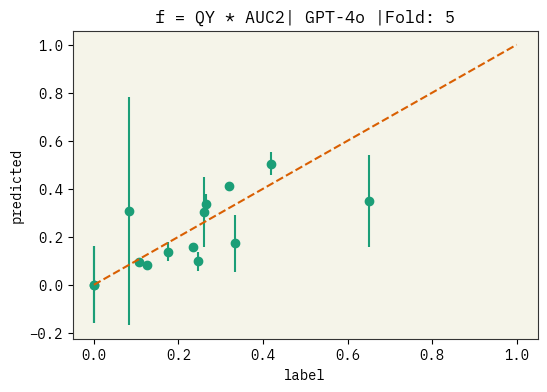

100%|██████████| 5/5 [04:43<00:00, 56.71s/it]

Run 0: 0.12 +/- 0.00
Run 1: 0.15 +/- 0.00
Run 2: 0.15 +/- 0.00
Run 3: 33.64 +/- 0.00
Run 4: 0.13 +/- 0.00


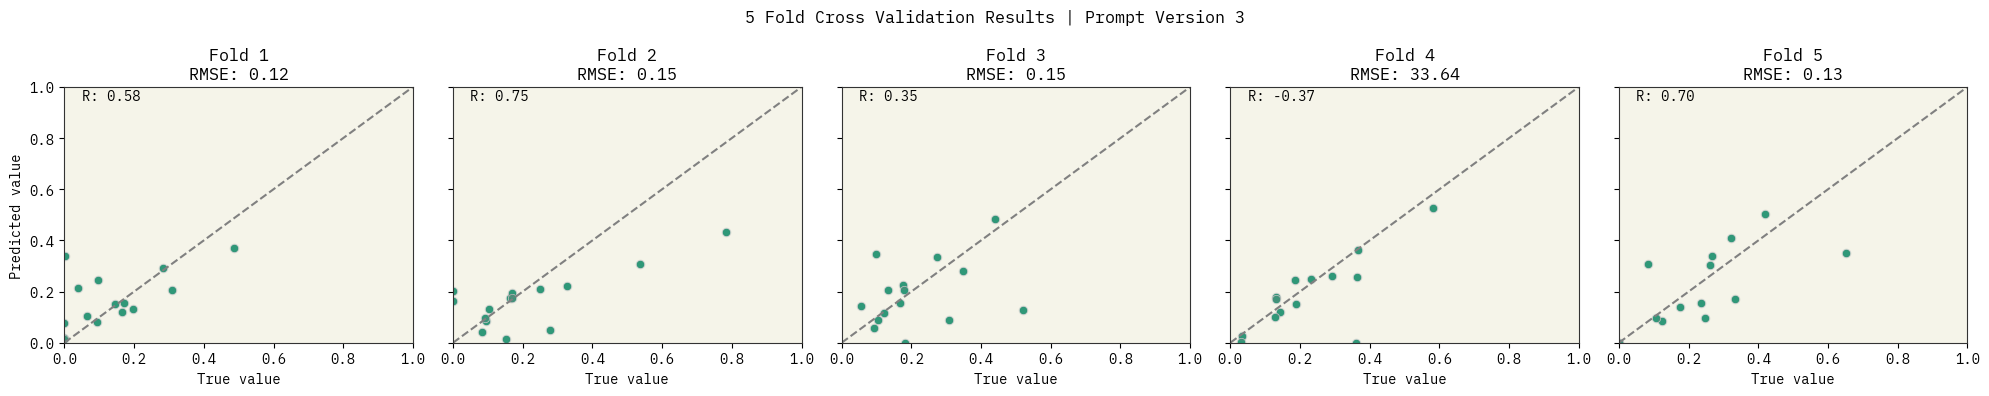

In [ ]:
yhat_3,std_hat_3,y_3= cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=3)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Use

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.13    |    0.09    |    0.03    |
|    0.11    |    0.17    |    0.05    |
|    0.15    |    0.23    |    0.08    |
|    0.31    |    0.08    |    0.22    |
|    0.11    |    0.36    |    0.26    |
|    0.00    |    0.03    |    0.03    |
|    0.77    |    0.36    |    0.41    |
|    0.00    |    0.28    |    0.28    |
|    0.08    |    0.06    |    0.02    |
|    0.08    |    0.09    |    0.02    |
|    0.15    |    0.31    |    0.15    |
|    0.17    |    0.78    |    0.61    |
|    0.16    |    0.10    |    0.06    |
|    0.18    |    0.13    |    0.05    |
|    0.89    |    0.54    |    0.35    |

              RMSE: 0.24              


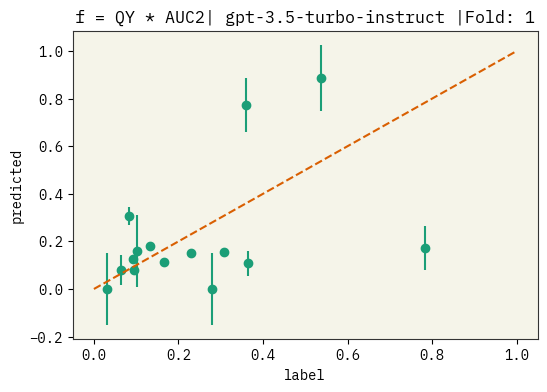

 20%|██        | 1/5 [00:53<03:35, 53.99s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.09    |    0.25    |    0.16    |
|    0.00    |    0.00    |    0.00    |
|    0.14    |    0.11    |    0.03    |
|    0.28    |    0.00    |    0.27    |
|    0.26    |    0.37    |    0.10    |
|    0.00    |    0.18    |    0.18    |
|    0.09    |    0.23    |    0.15    |
|    0.04    |    0.31    |    0.27    |
|    0.15    |    0.17    |    0.02    |
|    0.21    |    0.17    |    0.04    |
|    0.09    |    0.00    |    0.09    |
|    0.24    |    0.49    |    0.25    |
|    0.02    |    0.12    |    0.10    |
|    0.38    |    0.04    |    0.35    |
|    0.07    |    0.10    |    0.03    |

              RMSE: 0.17              


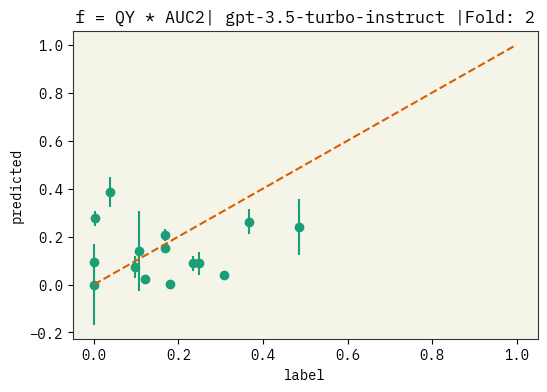

 40%|████      | 2/5 [01:44<02:36, 52.06s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.17    |    0.16    |    0.01    |
|    0.41    |    0.19    |    0.23    |
|    0.03    |    0.17    |    0.15    |
|    0.07    |    0.18    |    0.11    |
|    0.35    |    0.28    |    0.07    |
|    0.11    |    0.09    |    0.02    |
|    0.04    |    0.33    |    0.29    |
|    0.03    |    0.13    |    0.10    |
|    0.18    |    0.19    |    0.00    |
|    0.06    |    0.20    |    0.14    |
|    0.11    |    0.10    |    0.01    |
|    0.13    |    0.00    |    0.13    |
|    0.23    |    0.42    |    0.19    |
|    0.63    |    0.00    |    0.63    |
|    0.16    |    0.13    |    0.03    |

              RMSE: 0.21              


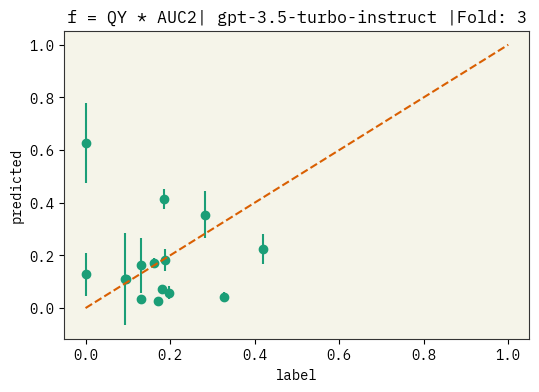

 60%|██████    | 3/5 [02:43<01:49, 54.95s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.09    |    0.12    |    0.03    |
|    0.21    |    0.35    |    0.14    |
|    0.08    |    0.13    |    0.05    |
|    0.46    |    0.33    |    0.13    |
|    0.09    |    0.14    |    0.05    |
|    0.18    |    0.29    |    0.11    |
|    0.06    |    0.15    |    0.09    |
|    0.08    |    0.00    |    0.08    |
|    0.27    |    0.44    |    0.18    |
|    0.03    |    0.00    |    0.03    |
|    0.09    |    0.10    |    0.02    |
|    0.06    |    0.09    |    0.04    |
|    0.12    |    0.27    |    0.15    |
|    0.29    |    0.58    |    0.29    |
|    0.24    |    0.18    |    0.06    |

              RMSE: 0.12              


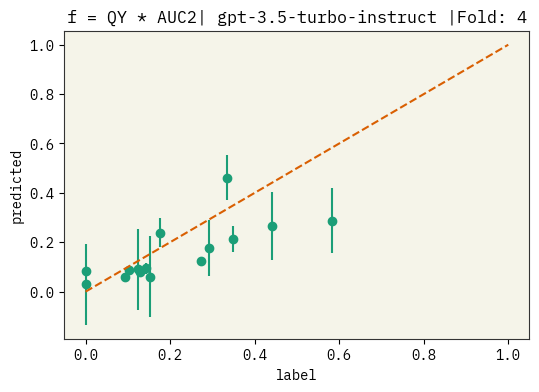

 80%|████████  | 4/5 [03:32<00:52, 52.82s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.01    |    0.00    |    0.01    |
|    0.02    |    0.03    |    0.01    |
|    0.22    |    0.25    |    0.03    |
|    0.09    |    0.52    |    0.43    |
|    0.08    |    0.14    |    0.06    |
|    0.31    |    0.08    |    0.22    |
|    0.01    |    0.00    |    0.01    |
|    0.06    |    0.32    |    0.26    |
|    0.23    |    0.06    |    0.17    |
|    0.18    |    0.17    |    0.01    |
|    0.25    |    0.27    |    0.01    |
|    0.16    |    0.17    |    0.01    |
|    0.32    |    0.26    |    0.06    |
|    0.25    |    0.65    |    0.40    |

              RMSE: 0.19              


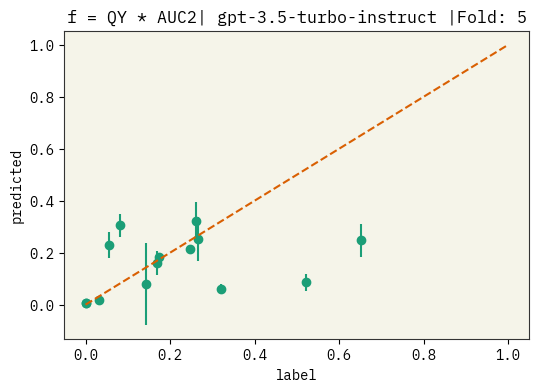

100%|██████████| 5/5 [04:30<00:00, 54.12s/it]

Run 0: 0.24 +/- 0.00
Run 1: 0.17 +/- 0.00
Run 2: 0.21 +/- 0.00
Run 3: 0.12 +/- 0.00
Run 4: 0.19 +/- 0.00


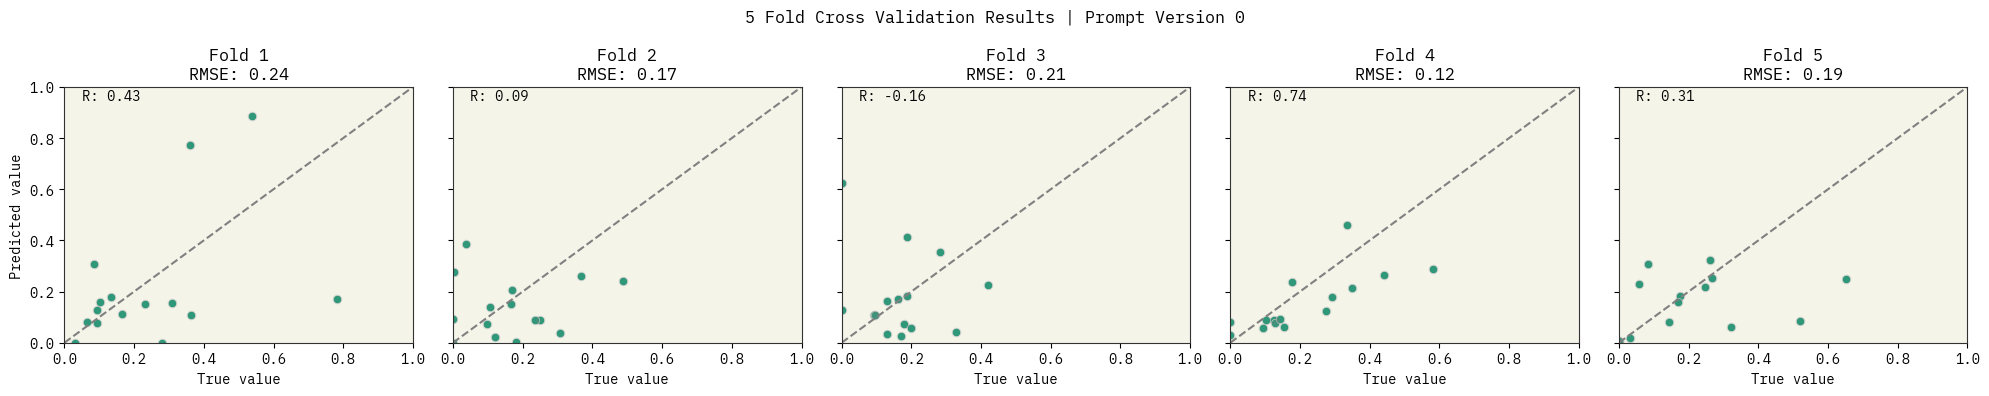

In [ ]:
yhat_0_gpt3_5,std_hat_0_gpt3_5,y_0_gpt3_5 = cv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=0)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Use

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.16    |    0.13    |    0.03    |
|    0.16    |    0.31    |    0.15    |
|    0.04    |    0.09    |    0.05    |
|    0.20    |    0.42    |    0.22    |
|    0.06    |    0.09    |    0.03    |
|    0.31    |    0.36    |    0.05    |
|    0.05    |    0.00    |    0.05    |
|    0.03    |    0.25    |    0.22    |
|    0.25    |    0.37    |    0.11    |
|    0.63    |    0.33    |    0.30    |
|    0.18    |    0.23    |    0.05    |
|    0.02    |    0.13    |    0.10    |
|    0.00    |    0.12    |    0.12    |
|    0.27    |    0.28    |    0.01    |
|    0.01    |    0.00    |    0.01    |

              RMSE: 0.13              


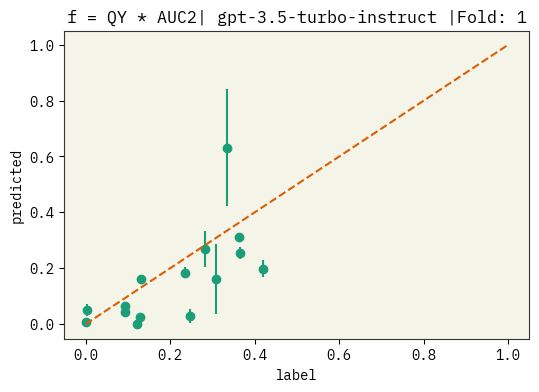

 20%|██        | 1/5 [00:53<03:34, 53.53s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.00    |    0.03    |    0.03    |
|    0.08    |    0.14    |    0.07    |
|    0.19    |    0.33    |    0.13    |
|    0.05    |    0.10    |    0.05    |
|    0.01    |    0.28    |    0.27    |
|    0.34    |    0.25    |    0.10    |
|    0.08    |    0.10    |    0.01    |
|    0.04    |    0.17    |    0.13    |
|    0.12    |    0.11    |    0.02    |
|    0.14    |    0.20    |    0.06    |
|    0.01    |    0.58    |    0.57    |
|    0.03    |    0.00    |    0.03    |
|    0.07    |    0.00    |    0.07    |
|    0.03    |    0.36    |    0.33    |
|    0.25    |    0.00    |    0.25    |

              RMSE: 0.21              


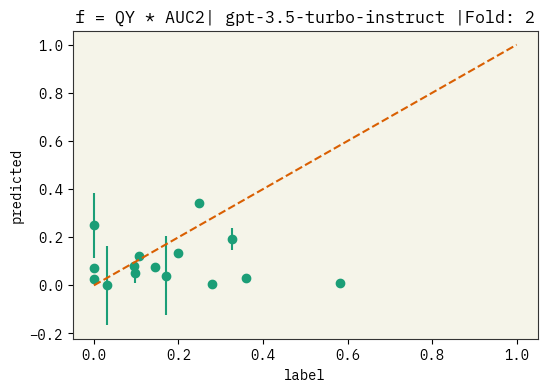

 40%|████      | 2/5 [01:42<02:32, 50.72s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.00    |    0.03    |    0.03    |
|    0.14    |    0.00    |    0.14    |
|    0.09    |    0.65    |    0.56    |
|    0.05    |    0.08    |    0.03    |
|    0.07    |    0.18    |    0.10    |
|    0.10    |    0.14    |    0.04    |
|    0.13    |    0.17    |    0.04    |
|    0.10    |    0.12    |    0.02    |
|    0.08    |    0.78    |    0.70    |
|    0.09    |    0.17    |    0.08    |
|    0.11    |    0.13    |    0.02    |
|    0.19    |    0.17    |    0.02    |
|    0.48    |    0.44    |    0.03    |
|    0.05    |    0.18    |    0.13    |
|    0.18    |    0.27    |    0.10    |

              RMSE: 0.24              


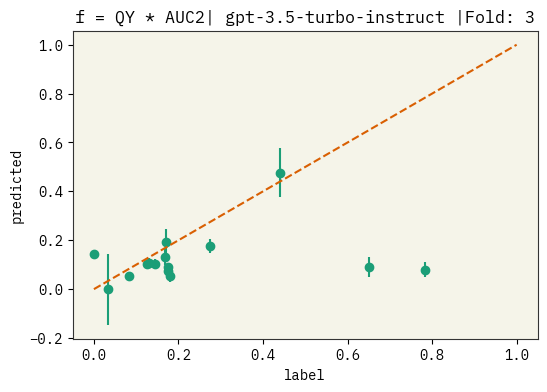

 60%|██████    | 3/5 [02:36<01:44, 52.23s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.34    |    0.26    |    0.08    |
|    0.02    |    0.16    |    0.14    |
|    0.67    |    0.54    |    0.13    |
|    0.00    |    0.00    |    0.00    |
|    0.01    |    0.06    |    0.05    |
|    0.15    |    0.17    |    0.02    |
|    0.01    |    0.52    |    0.51    |
|    0.01    |    0.15    |    0.15    |
|    0.00    |    0.00    |    0.00    |
|    0.17    |    0.23    |    0.06    |
|    0.13    |    0.32    |    0.19    |
|    0.27    |    0.19    |    0.09    |
|    0.09    |    0.10    |    0.01    |
|    0.24    |    0.13    |    0.11    |
|    0.09    |    0.09    |    0.00    |

              RMSE: 0.16              


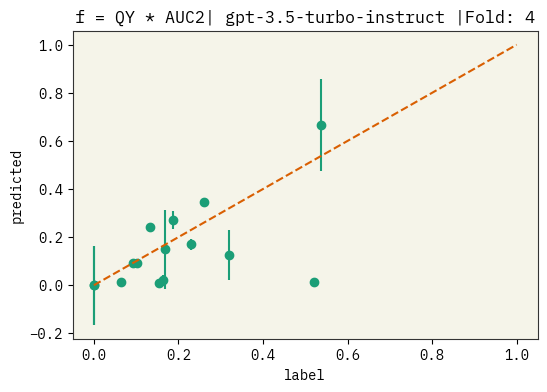

 80%|████████  | 4/5 [03:40<00:57, 57.06s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/llm_model.py:124: UserWarning: Parameters {'logprobs'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  return OpenAILLM(**kwargs)
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.10    |    0.09    |    0.01    |
|    0.03    |    0.31    |    0.28    |
|    0.01    |    0.27    |    0.25    |
|    0.67    |    0.49    |    0.19    |
|    0.17    |    0.04    |    0.13    |
|    0.07    |    0.18    |    0.11    |
|    0.02    |    0.35    |    0.33    |
|    0.21    |    0.29    |    0.08    |
|    0.05    |    0.00    |    0.05    |
|    0.13    |    0.17    |    0.04    |
|    0.05    |    0.10    |    0.05    |
|    0.24    |    0.06    |    0.18    |
|    0.13    |    0.19    |    0.06    |
|    0.29    |    0.08    |    0.20    |

              RMSE: 0.17              


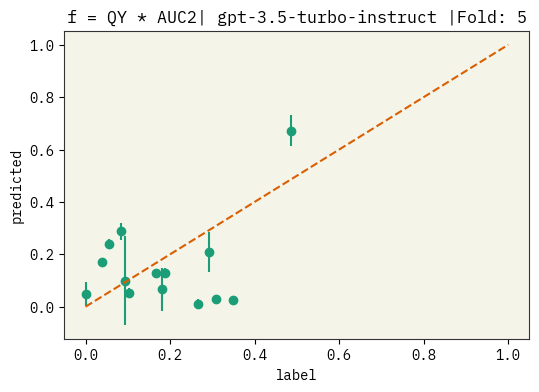

100%|██████████| 5/5 [04:25<00:00, 53.07s/it]


Run 0: 0.13 +/- 0.00
Run 1: 0.21 +/- 0.00
Run 2: 0.24 +/- 0.00
Run 3: 0.16 +/- 0.00
Run 4: 0.17 +/- 0.00


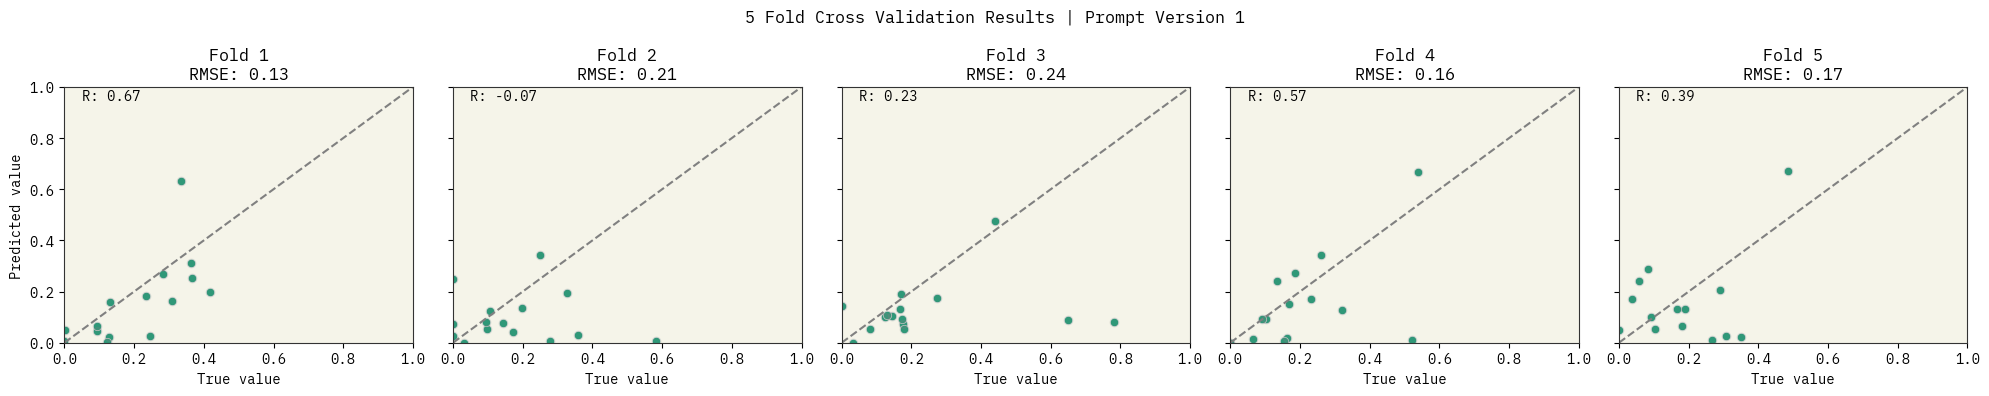

In [ ]:
yhat_1_gpt3_5,std_hat_1_gpt3_5,y_1_gpt3_5 = cv_asktell(df, model="gpt-3.5-turbo-instruct", selector_k=5, temperature=0.7,prompt_version=1)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.30    |    0.37    |    0.07    |
|    0.17    |    0.13    |    0.04    |
|    0.25    |    0.25    |    0.01    |
|    0.19    |    0.04    |    0.15    |
|    0.08    |    0.00    |    0.08    |
|    0.34    |    0.65    |    0.31    |
|    0.15    |    0.17    |    0.02    |
|    0.00    |    0.28    |    0.28    |
|    0.15    |    0.17    |    0.02    |
|    0.31    |    0.54    |    0.23    |
|    0.35    |    0.26    |    0.09    |
|    0.08    |    0.49    |    0.41    |
|    0.15    |    0.58    |    0.43    |
|    0.16    |    0.00    |    0.16    |
|    0.15    |    0.10    |    0.06    |

              RMSE: 0.21              


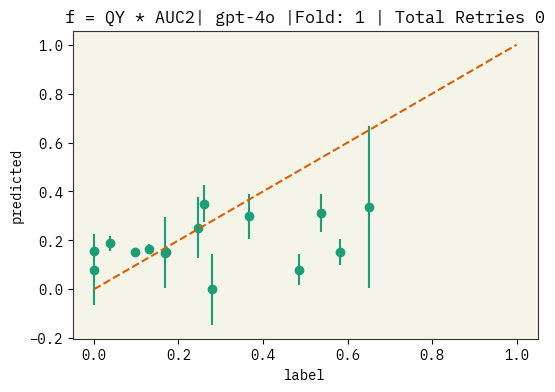

 20%|██        | 1/5 [01:06<04:24, 66.18s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.42    |    0.78    |    0.36    |
|    0.32    |    0.29    |    0.02    |
|    0.10    |    0.17    |    0.07    |
|    0.05    |    0.09    |    0.04    |
|    0.14    |    0.52    |    0.38    |
|    0.15    |    0.31    |    0.16    |
|    0.17    |    0.18    |    0.01    |
|    0.20    |    0.27    |    0.07    |
|    0.15    |    0.14    |    0.01    |
|    0.41    |    0.19    |    0.22    |
|    0.34    |    0.33    |    0.01    |
|    0.00    |    0.00    |    0.00    |
|    0.45    |    0.36    |    0.09    |
|    0.10    |    0.10    |    0.00    |
|    0.17    |    0.23    |    0.07    |

              RMSE: 0.16              


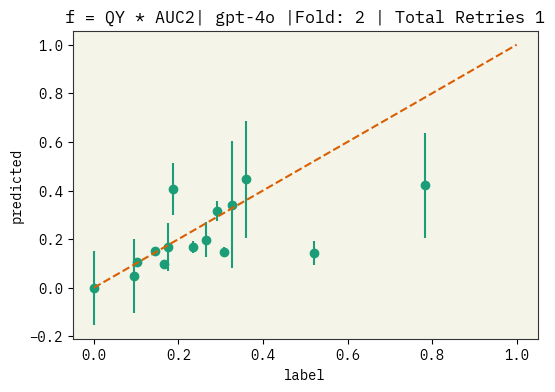

 40%|████      | 2/5 [02:05<03:06, 62.32s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.21    |    0.08    |    0.12    |
|    0.10    |    0.20    |    0.09    |
|    0.25    |    0.13    |    0.12    |
|    0.11    |    0.17    |    0.06    |
|    0.09    |    0.42    |    0.33    |
|    0.24    |    0.17    |    0.07    |
|    0.06    |    0.31    |    0.25    |
|    0.12    |    0.10    |    0.02    |
|    0.03    |    0.00    |    0.03    |
|    0.19    |    0.13    |    0.05    |
|    0.01    |    0.15    |    0.15    |
|    0.30    |    0.27    |    0.03    |
|    0.12    |    0.12    |    0.00    |
|    0.18    |    0.44    |    0.26    |
|    0.16    |    0.25    |    0.09    |

              RMSE: 0.15              


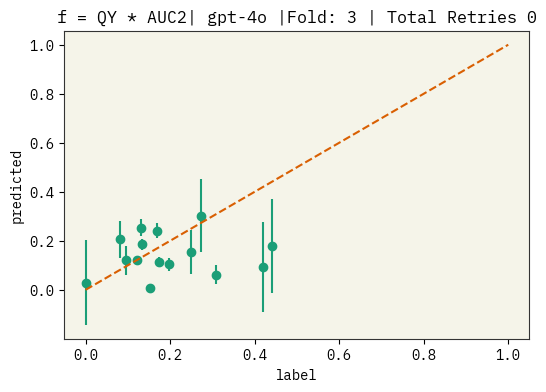

 60%|██████    | 3/5 [02:52<01:50, 55.03s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.31    |    0.28    |    0.03    |
|    0.24    |    0.32    |    0.08    |
|    0.29    |    0.00    |    0.29    |
|    0.10    |    0.13    |    0.03    |
|    0.42    |    0.00    |    0.42    |
|    0.07    |    0.09    |    0.02    |
|    0.00    |    0.00    |    0.00    |
|    0.37    |    0.33    |    0.03    |
|    0.16    |    0.08    |    0.08    |
|    0.02    |    0.03    |    0.02    |
|    0.20    |    0.19    |    0.01    |
|    0.08    |    0.17    |    0.09    |
|    0.13    |    0.00    |    0.13    |
|    0.22    |    0.36    |    0.15    |
|    0.22    |    0.06    |    0.16    |

              RMSE: 0.15              


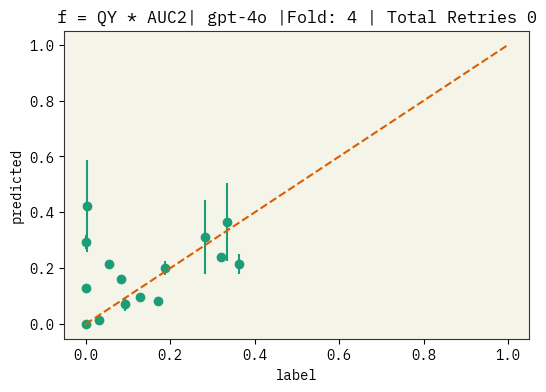

 80%|████████  | 4/5 [03:39<00:52, 52.04s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.11    |    0.14    |    0.03    |
|    0.25    |    0.18    |    0.07    |
|    0.09    |    0.10    |    0.01    |
|    0.00    |    0.00    |    0.00    |
|    0.24    |    0.23    |    0.01    |
|    0.09    |    0.12    |    0.03    |
|    0.09    |    0.09    |    0.00    |
|    0.48    |    0.35    |    0.13    |
|    0.03    |    0.06    |    0.04    |
|    0.02    |    0.16    |    0.14    |
|    0.09    |    0.11    |    0.01    |
|    0.17    |    0.09    |    0.08    |
|    0.00    |    0.18    |    0.18    |
|    0.06    |    0.03    |    0.03    |

              RMSE: 0.08              


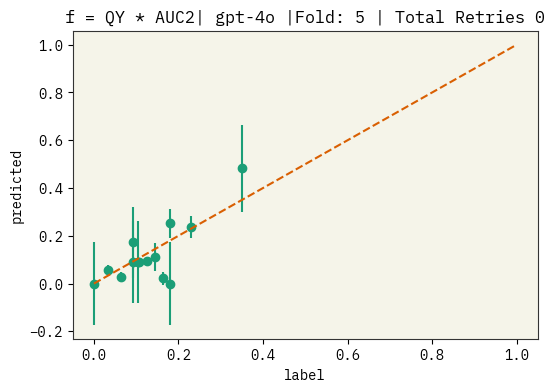

100%|██████████| 5/5 [04:24<00:00, 52.96s/it]

Run 0: 0.21 +/- 0.00
Run 1: 0.16 +/- 0.00
Run 2: 0.15 +/- 0.00
Run 3: 0.15 +/- 0.00
Run 4: 0.08 +/- 0.00


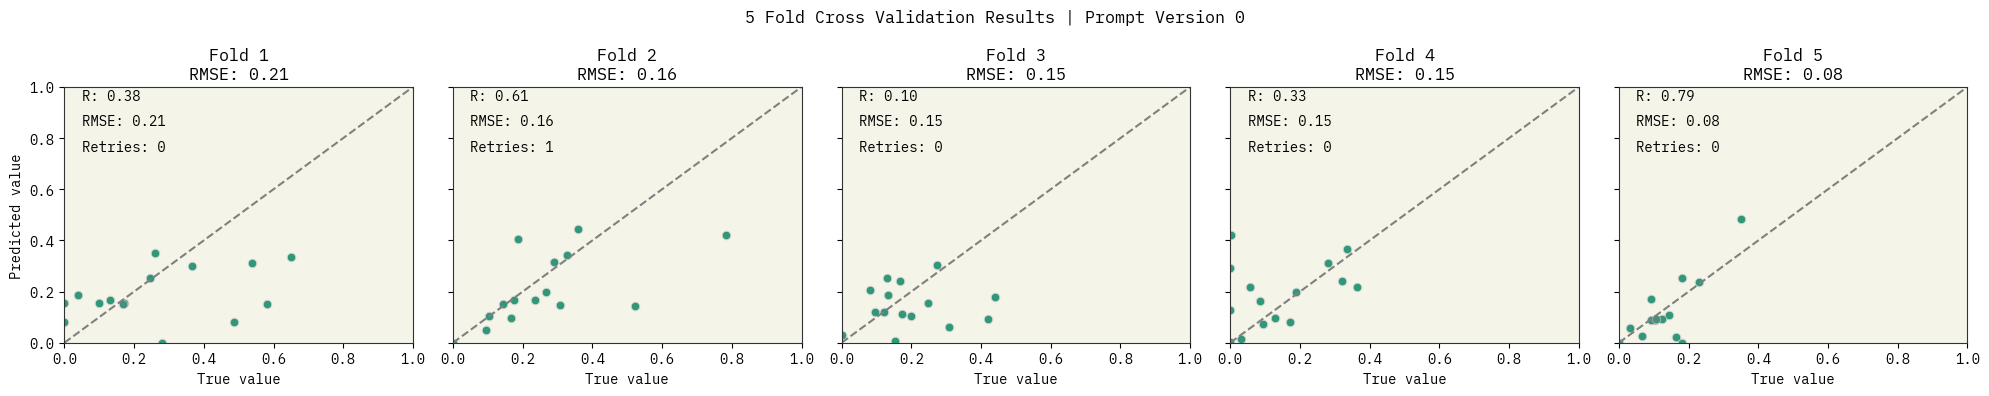

In [ ]:
yhat_0_gpt4,std_hat_0_gpt4,y_0_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=0)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.46    |    0.78    |    0.32    |
|    0.11    |    0.12    |    0.02    |
|    0.25    |    0.13    |    0.12    |
|    0.11    |    0.09    |    0.01    |
|    0.00    |    0.03    |    0.03    |
|    0.00    |    0.03    |    0.03    |
|    0.21    |    0.06    |    0.14    |
|    0.02    |    0.00    |    0.02    |
|    0.13    |    0.17    |    0.04    |
|    0.09    |    0.09    |    0.00    |
|    0.15    |    0.14    |    0.01    |
|    0.49    |    0.44    |    0.05    |
|    0.14    |    0.00    |    0.14    |
|    0.26    |    0.06    |    0.20    |
|    0.05    |    0.08    |    0.03    |

              RMSE: 0.12              


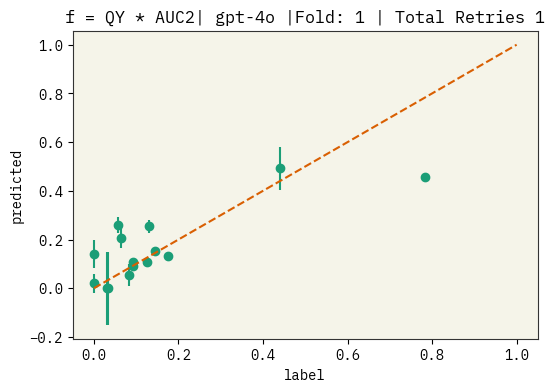

 20%|██        | 1/5 [01:05<04:21, 65.49s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.17    |    0.04    |    0.13    |
|    0.18    |    0.31    |    0.12    |
|    0.01    |    0.52    |    0.51    |
|    0.13    |    0.18    |    0.04    |
|    0.01    |    0.16    |    0.16    |
|    0.38    |    0.42    |    0.04    |
|    0.38    |    0.00    |    0.38    |
|    0.00    |    0.18    |    0.18    |
|    0.22    |    0.13    |    0.08    |
|    0.34    |    0.28    |    0.06    |
|    0.49    |    0.36    |    0.13    |
|    0.00    |    0.15    |    0.15    |
|    0.63    |    0.49    |    0.14    |
|    0.17    |    0.14    |    0.03    |
|    0.23    |    0.27    |    0.03    |

              RMSE: 0.20              


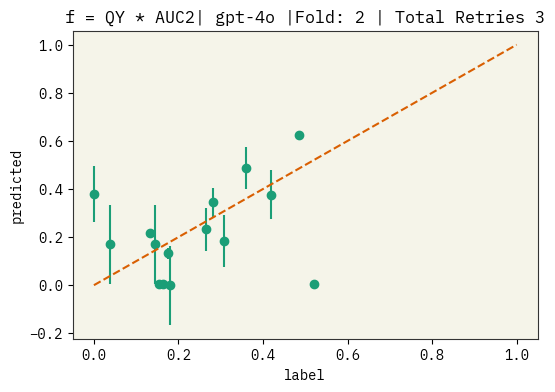

 40%|████      | 2/5 [02:23<03:37, 72.59s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.28    |    0.33    |    0.05    |
|    0.22    |    0.65    |    0.43    |
|    0.15    |    0.17    |    0.02    |
|    0.15    |    0.27    |    0.13    |
|    0.20    |    0.13    |    0.07    |
|    0.07    |    0.12    |    0.05    |
|    0.20    |    0.58    |    0.38    |
|    0.31    |    0.19    |    0.12    |
|    0.16    |    0.25    |    0.08    |
|    0.10    |    0.11    |    0.00    |
|    0.16    |    0.23    |    0.07    |
|    0.33    |    0.54    |    0.21    |
|    0.03    |    0.00    |    0.03    |
|    0.15    |    0.35    |    0.20    |
|    0.57    |    0.33    |    0.24    |

              RMSE: 0.19              


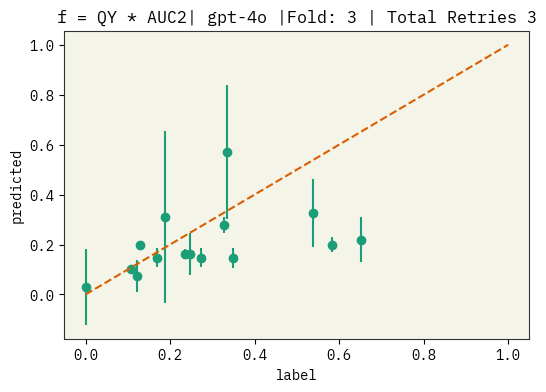

 60%|██████    | 3/5 [03:32<02:22, 71.30s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.41    |    0.09    |    0.32    |
|    0.13    |    0.17    |    0.04    |
|    0.19    |    0.00    |    0.19    |
|    0.12    |    0.17    |    0.05    |
|    0.18    |    0.10    |    0.08    |
|    0.09    |    0.20    |    0.11    |
|    0.06    |    0.09    |    0.04    |
|    0.26    |    0.17    |    0.09    |
|    0.33    |    0.00    |    0.33    |
|    0.26    |    0.23    |    0.03    |
|    0.31    |    0.26    |    0.04    |
|    0.14    |    0.00    |    0.14    |
|    0.08    |    0.10    |    0.01    |
|    0.35    |    0.25    |    0.11    |
|    0.29    |    0.13    |    0.16    |

              RMSE: 0.15              


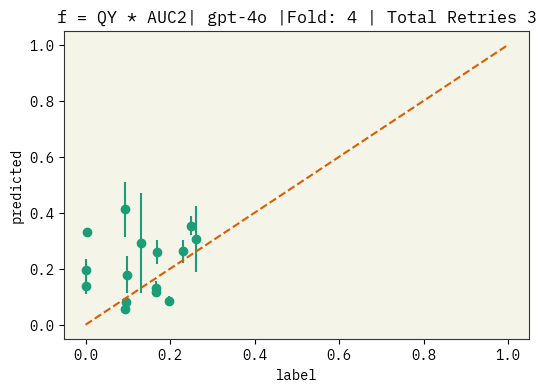

 80%|████████  | 4/5 [04:41<01:10, 70.36s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.00    |    0.00    |    0.00    |
|    0.29    |    0.37    |    0.08    |
|    0.00    |    0.28    |    0.28    |
|    0.05    |    0.17    |    0.12    |
|    0.10    |    0.10    |    0.00    |
|    0.25    |    0.18    |    0.07    |
|    0.23    |    0.36    |    0.13    |
|    0.20    |    0.08    |    0.12    |
|    0.44    |    0.29    |    0.14    |
|    0.15    |    0.31    |    0.16    |
|    0.09    |    0.10    |    0.01    |
|    0.22    |    0.19    |    0.03    |
|    0.08    |    0.00    |    0.08    |
|    0.21    |    0.32    |    0.11    |

              RMSE: 0.12              


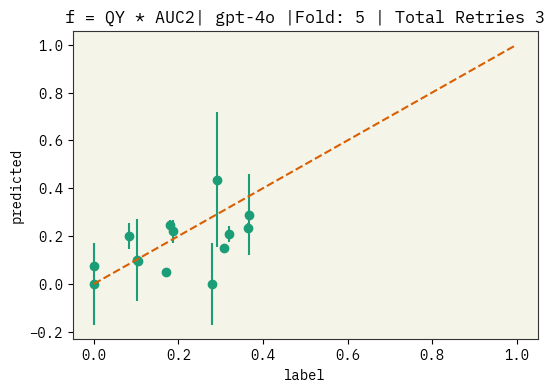

100%|██████████| 5/5 [05:50<00:00, 70.10s/it]

Run 0: 0.12 +/- 0.00
Run 1: 0.20 +/- 0.00
Run 2: 0.19 +/- 0.00
Run 3: 0.15 +/- 0.00
Run 4: 0.12 +/- 0.00


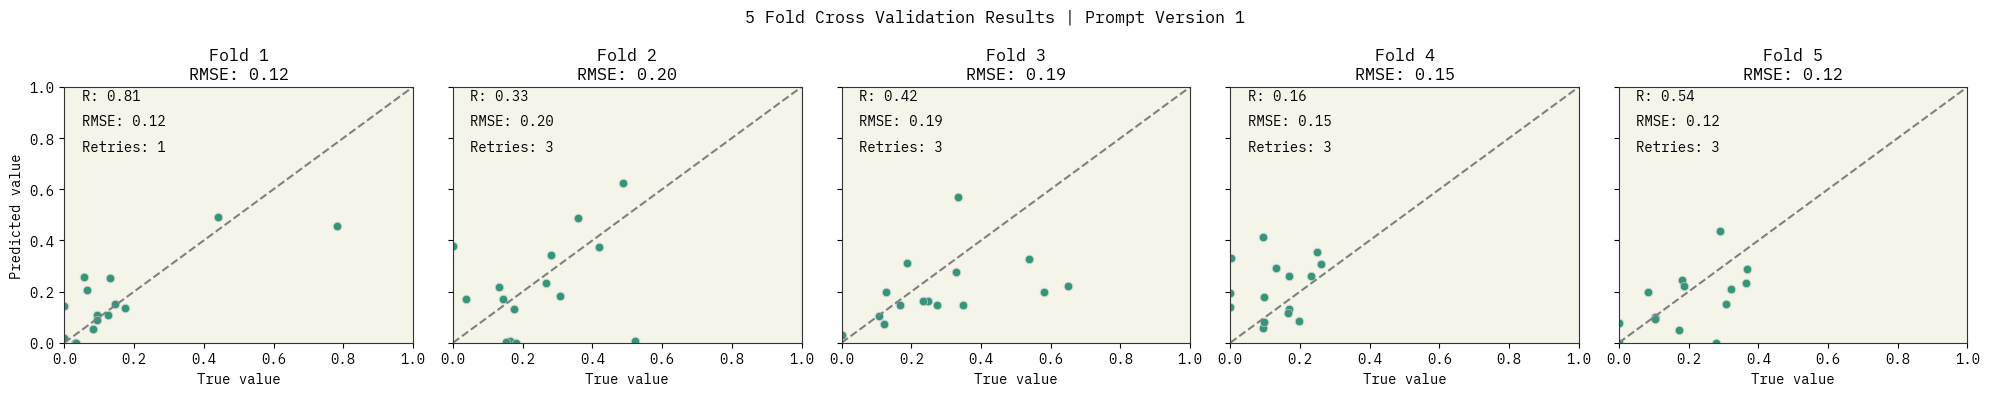

In [ ]:
yhat_1_gpt4,std_hat_1_gpt4,y_1_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=1)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.18    |    0.16    |    0.01    |
|    0.14    |    0.23    |    0.09    |
|    0.13    |    0.17    |    0.04    |
|    0.39    |    0.49    |    0.09    |
|    0.30    |    0.29    |    0.01    |
|    0.32    |    0.33    |    0.01    |
|    0.05    |    0.08    |    0.03    |
|    0.11    |    0.09    |    0.02    |
|    0.44    |    0.54    |    0.10    |
|    0.17    |    0.13    |    0.03    |
|    0.22    |    0.18    |    0.04    |
|    0.05    |    0.23    |    0.18    |
|    0.26    |    0.58    |    0.32    |
|    0.12    |    0.11    |    0.01    |
|    0.16    |    0.31    |    0.15    |

              RMSE: 0.11              


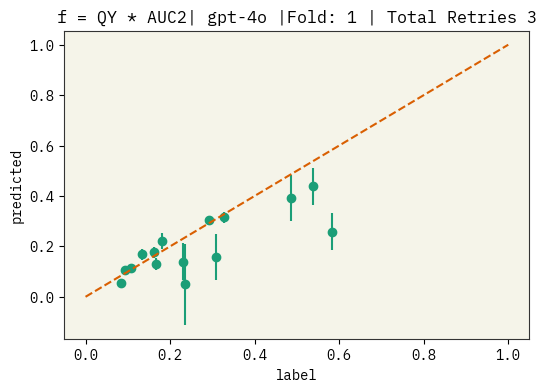

 20%|██        | 1/5 [01:18<05:12, 78.06s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.07    |    0.09    |    0.02    |
|    0.12    |    0.17    |    0.04    |
|    0.59    |    0.36    |    0.23    |
|    0.52    |    0.00    |    0.52    |
|    0.14    |    0.31    |    0.17    |
|    0.17    |    0.00    |    0.17    |
|    0.14    |    0.17    |    0.02    |
|    0.22    |    0.27    |    0.05    |
|    0.29    |    0.28    |    0.00    |
|    0.09    |    0.17    |    0.08    |
|    0.10    |    0.13    |    0.03    |
|    0.14    |    0.14    |    0.01    |
|    0.09    |    0.10    |    0.00    |
|    0.08    |    0.09    |    0.01    |
|    0.04    |    0.52    |    0.48    |

              RMSE: 0.20              


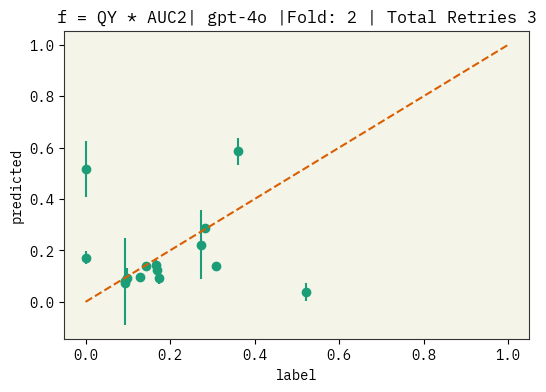

 40%|████      | 2/5 [02:26<03:36, 72.11s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.06    |    0.00    |    0.06    |
|    0.02    |    0.00    |    0.02    |
|    0.04    |    0.14    |    0.10    |
|    0.17    |    0.15    |    0.02    |
|    0.07    |    0.10    |    0.03    |
|    0.12    |    0.19    |    0.07    |
|    0.10    |    0.10    |    0.01    |
|    0.37    |    0.25    |    0.12    |
|    0.26    |    0.17    |    0.09    |
|    0.03    |    0.00    |    0.03    |
|    0.44    |    0.32    |    0.12    |
|    0.37    |    0.65    |    0.28    |
|    0.05    |    0.09    |    0.05    |
|    0.07    |    0.17    |    0.10    |
|    0.03    |    0.03    |    0.00    |

              RMSE: 0.10              


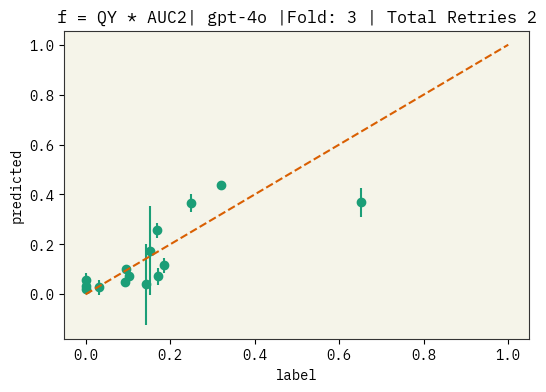

 60%|██████    | 3/5 [03:32<02:19, 69.72s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.10    |    0.12    |    0.02    |
|    0.83    |    0.28    |    0.55    |
|    0.34    |    0.42    |    0.08    |
|    0.47    |    0.78    |    0.31    |
|    0.08    |    0.00    |    0.08    |
|    0.12    |    0.06    |    0.05    |
|    0.16    |    0.13    |    0.03    |
|    0.12    |    0.19    |    0.06    |
|    0.02    |    0.00    |    0.02    |
|    0.39    |    0.00    |    0.39    |
|    0.14    |    0.04    |    0.10    |
|    0.09    |    0.33    |    0.24    |
|    0.28    |    0.36    |    0.08    |
|    0.11    |    0.18    |    0.07    |
|    0.27    |    0.37    |    0.10    |

              RMSE: 0.21              


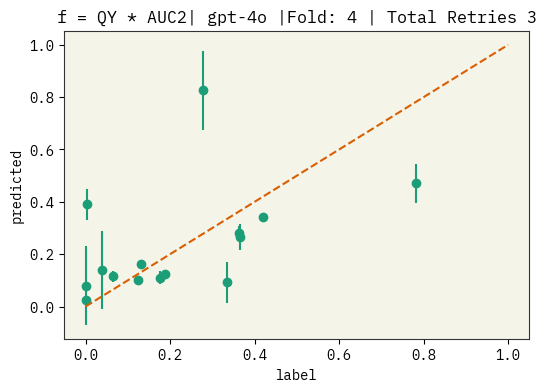

 80%|████████  | 4/5 [04:50<01:12, 72.85s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.10    |    0.00    |    0.10    |
|    0.00    |    0.18    |    0.18    |
|    0.10    |    0.10    |    0.00    |
|    0.02    |    0.03    |    0.01    |
|    0.36    |    0.13    |    0.23    |
|    0.43    |    0.26    |    0.17    |
|    0.33    |    0.35    |    0.02    |
|    0.03    |    0.08    |    0.05    |
|    0.26    |    0.25    |    0.02    |
|    0.44    |    0.44    |    0.00    |
|    0.18    |    0.27    |    0.09    |
|    0.15    |    0.12    |    0.03    |
|    0.09    |    0.20    |    0.11    |
|    0.20    |    0.06    |    0.14    |

              RMSE: 0.11              


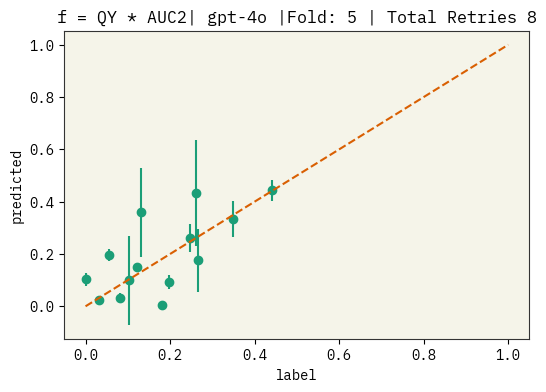

100%|██████████| 5/5 [06:35<00:00, 79.14s/it]

Run 0: 0.11 +/- 0.00
Run 1: 0.20 +/- 0.00
Run 2: 0.10 +/- 0.00
Run 3: 0.21 +/- 0.00
Run 4: 0.11 +/- 0.00


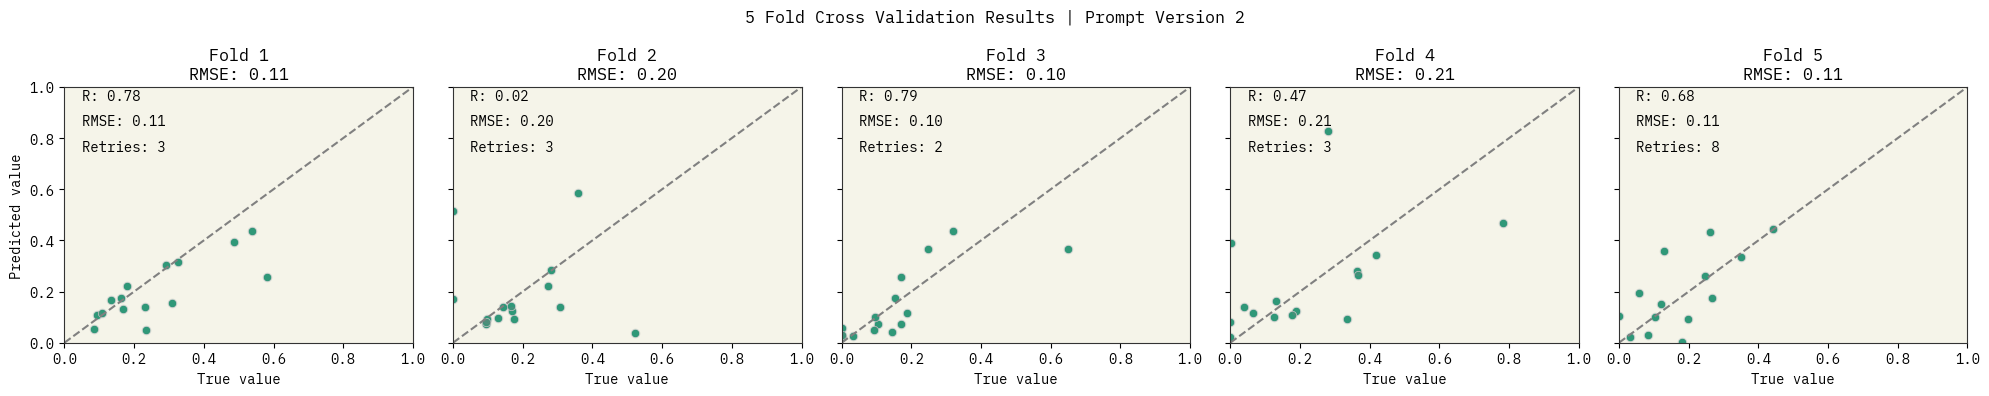

In [ ]:
yhat_2_gpt4,std_hat_2_gpt4,y_2_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=2)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.16    |    0.10    |    0.07    |
|    0.15    |    0.17    |    0.02    |
|    0.05    |    0.09    |    0.05    |
|    0.10    |    0.36    |    0.26    |
|    0.26    |    0.36    |    0.10    |
|    0.12    |    0.17    |    0.05    |
|    0.00    |    0.27    |    0.27    |
|    0.38    |    0.27    |    0.11    |
|    0.07    |    0.10    |    0.03    |
|    0.53    |    0.54    |    0.01    |
|    0.11    |    0.20    |    0.09    |
|    0.12    |    0.10    |    0.02    |
|    0.27    |    0.65    |    0.38    |
|    0.03    |    0.28    |    0.25    |
|    0.06    |    0.17    |    0.11    |

              RMSE: 0.16              


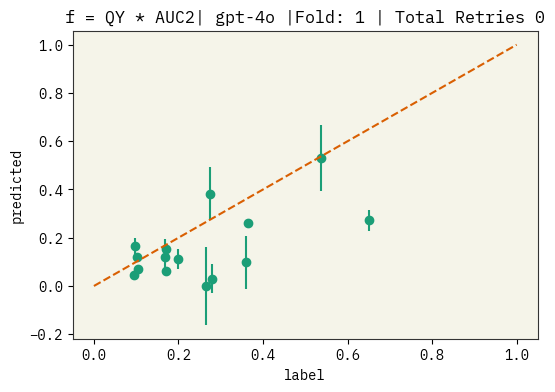

 20%|██        | 1/5 [00:52<03:28, 52.20s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.25    |    0.11    |
|    0.30    |    0.78    |    0.49    |
|    0.42    |    0.35    |    0.07    |
|    0.17    |    0.08    |    0.09    |
|    0.00    |    0.00    |    0.00    |
|    0.35    |    0.49    |    0.14    |
|    0.00    |    0.00    |    0.00    |
|    0.41    |    0.32    |    0.09    |
|    0.27    |    0.33    |    0.05    |
|    0.26    |    0.29    |    0.03    |
|    0.34    |    0.42    |    0.08    |
|    0.10    |    0.09    |    0.01    |
|    0.00    |    0.18    |    0.18    |
|    0.31    |    0.37    |    0.06    |
|    0.42    |    0.00    |    0.41    |

              RMSE: 0.18              


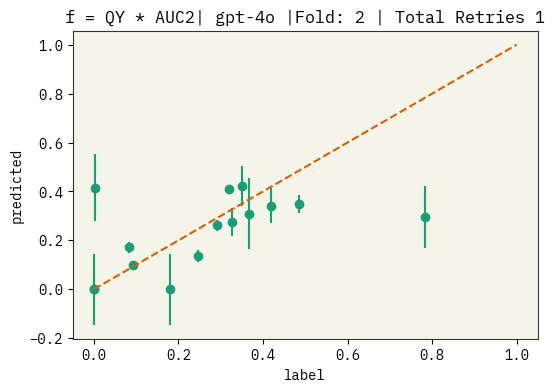

 40%|████      | 2/5 [01:59<03:02, 60.80s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.00    |    0.14    |
|    0.01    |    0.03    |    0.02    |
|    0.10    |    0.13    |    0.03    |
|    0.25    |    0.33    |    0.08    |
|    0.26    |    0.44    |    0.18    |
|    0.10    |    0.09    |    0.01    |
|    0.17    |    0.06    |    0.11    |
|    0.30    |    0.28    |    0.02    |
|    0.25    |    0.25    |    0.01    |
|    0.06    |    0.03    |    0.03    |
|    0.12    |    0.17    |    0.04    |
|    0.19    |    0.13    |    0.05    |
|    0.02    |    0.00    |    0.02    |
|    0.39    |    0.58    |    0.19    |
|    0.17    |    0.16    |    0.01    |

              RMSE: 0.09              


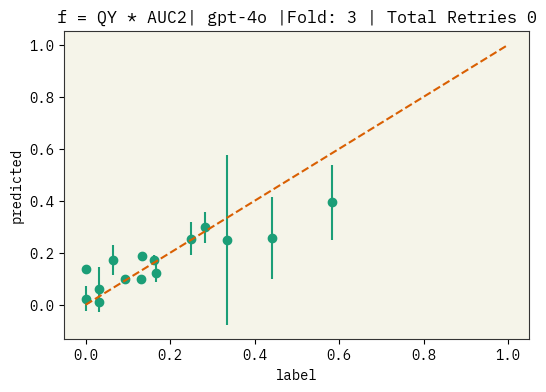

 60%|██████    | 3/5 [02:51<01:53, 56.85s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.00    |    0.14    |
|    0.17    |    0.14    |    0.03    |
|    0.20    |    0.14    |    0.06    |
|    0.10    |    0.12    |    0.02    |
|    0.08    |    0.00    |    0.08    |
|    0.10    |    0.09    |    0.00    |
|    0.17    |    0.13    |    0.04    |
|    0.17    |    0.04    |    0.13    |
|    0.22    |    0.26    |    0.04    |
|    0.10    |    0.11    |    0.01    |
|    0.02    |    0.15    |    0.13    |
|    0.07    |    0.18    |    0.11    |
|    0.17    |    0.19    |    0.01    |
|    0.09    |    0.17    |    0.08    |
|    0.10    |    0.10    |    0.00    |

              RMSE: 0.08              


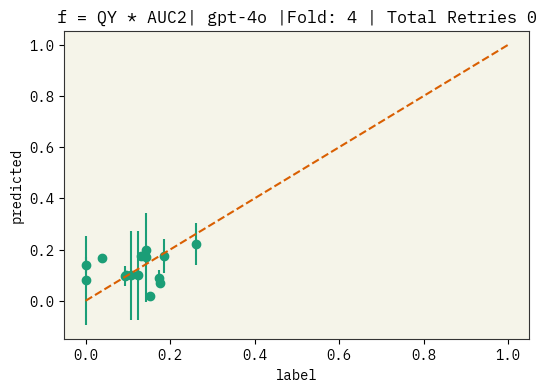

 80%|████████  | 4/5 [04:18<01:09, 69.04s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.18    |    0.31    |    0.13    |
|    0.14    |    0.08    |    0.06    |
|    0.12    |    0.17    |    0.05    |
|    0.35    |    0.00    |    0.35    |
|    0.07    |    0.23    |    0.16    |
|    0.10    |    0.31    |    0.21    |
|    0.15    |    0.19    |    0.04    |
|    0.00    |    0.00    |    0.00    |
|    0.15    |    0.06    |    0.09    |
|    0.05    |    0.12    |    0.07    |
|    0.27    |    0.13    |    0.14    |
|    0.05    |    0.23    |    0.18    |
|    0.25    |    0.52    |    0.27    |
|    0.23    |    0.18    |    0.05    |

              RMSE: 0.16              


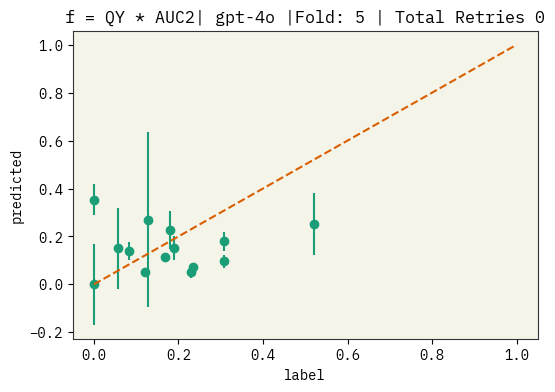

100%|██████████| 5/5 [05:14<00:00, 62.81s/it]

Run 0: 0.16 +/- 0.00
Run 1: 0.18 +/- 0.00
Run 2: 0.09 +/- 0.00
Run 3: 0.08 +/- 0.00
Run 4: 0.16 +/- 0.00


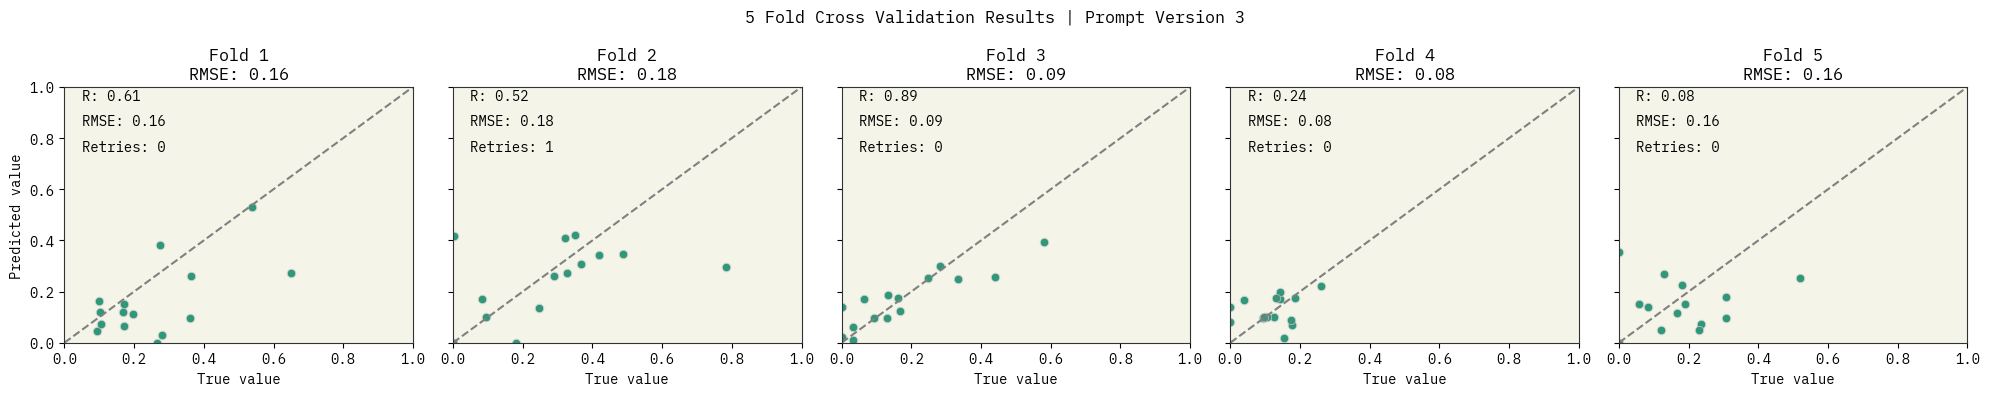

In [ ]:
yhat_3_gpt4,std_hat_3_gpt4,y_3_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=3)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.07    |    0.00    |    0.07    |
|    0.04    |    0.11    |    0.07    |
|    0.09    |    0.17    |    0.08    |
|    0.15    |    0.25    |    0.10    |
|    0.21    |    0.37    |    0.16    |
|    0.11    |    0.00    |    0.11    |
|    0.33    |    0.28    |    0.05    |
|    0.34    |    0.19    |    0.15    |
|    0.19    |    0.18    |    0.01    |
|    0.18    |    0.33    |    0.16    |
|    0.36    |    0.58    |    0.22    |
|    0.13    |    0.18    |    0.05    |
|    0.13    |    0.13    |    0.00    |

              RMSE: 0.11              


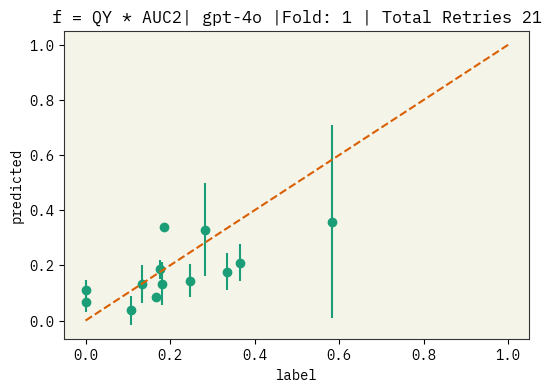

 20%|██        | 1/5 [03:16<13:05, 196.44s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.31    |    0.17    |
|    0.00    |    0.00    |    0.00    |
|    0.20    |    0.00    |    0.20    |
|    0.34    |    0.42    |    0.08    |
|    0.15    |    0.17    |    0.03    |
|    0.04    |    0.03    |    0.01    |
|    0.88    |    0.36    |    0.52    |
|    0.12    |    0.13    |    0.01    |
|    0.16    |    0.17    |    0.01    |
|    0.33    |    0.44    |    0.11    |
|    0.09    |    0.10    |    0.01    |
|    0.09    |    0.00    |    0.09    |
|    0.06    |    0.03    |    0.02    |
|    0.20    |    0.52    |    0.32    |
|    0.25    |    0.04    |    0.21    |

              RMSE: 0.19              


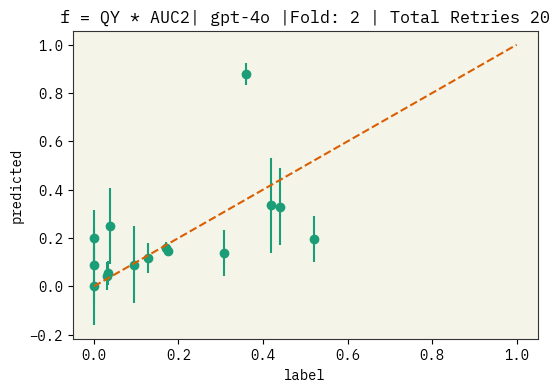

 40%|████      | 2/5 [05:37<08:12, 164.14s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.14    |    0.17    |    0.02    |
|    0.05    |    0.00    |    0.05    |
|    0.12    |    0.14    |    0.02    |
|    0.17    |    0.32    |    0.15    |
|    0.48    |    0.00    |    0.48    |
|    0.12    |    0.06    |    0.06    |
|    0.18    |    0.36    |    0.18    |
|    0.09    |    0.27    |    0.18    |
|    0.41    |    0.27    |    0.15    |
|    0.12    |    0.20    |    0.08    |
|    0.28    |    0.26    |    0.02    |
|    0.19    |    0.29    |    0.11    |
|    0.12    |    0.13    |    0.01    |
|    0.14    |    0.14    |    0.01    |
|    0.46    |    0.28    |    0.18    |

              RMSE: 0.16              


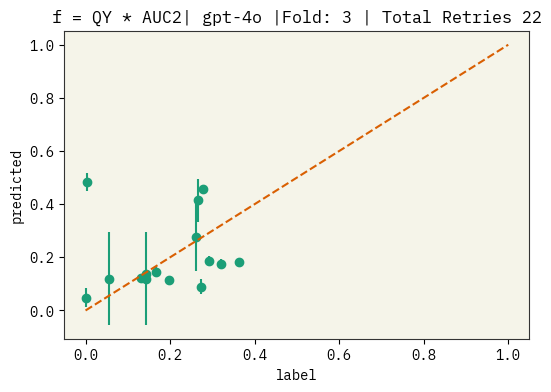

 60%|██████    | 3/5 [09:21<06:22, 191.16s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktel

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.28    |    0.33    |    0.05    |
|    0.45    |    0.78    |    0.33    |
|    0.22    |    0.10    |    0.12    |
|    0.20    |    0.17    |    0.02    |
|    0.15    |    0.12    |    0.03    |
|    0.35    |    0.54    |    0.19    |
|    0.29    |    0.49    |    0.19    |
|    0.15    |    0.19    |    0.04    |
|    0.15    |    0.25    |    0.10    |
|    0.20    |    0.35    |    0.15    |
|    0.32    |    0.17    |    0.15    |
|    0.23    |    0.09    |    0.13    |
|    0.22    |    0.13    |    0.09    |

              RMSE: 0.15              


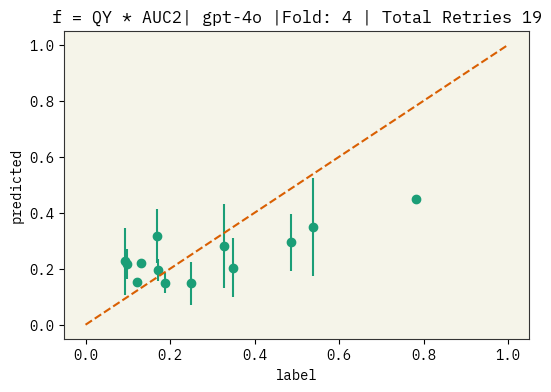

 80%|████████  | 4/5 [12:14<03:04, 184.14s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying
Too many retries, breaking


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.02    |    0.00    |    0.02    |
|    0.26    |    0.08    |    0.18    |
|    0.27    |    0.23    |    0.04    |
|    0.18    |    0.08    |    0.10    |
|    0.29    |    0.65    |    0.36    |
|    0.18    |    0.16    |    0.02    |
|    0.18    |    0.31    |    0.13    |
|    0.02    |    0.15    |    0.13    |
|    0.03    |    0.06    |    0.03    |
|    0.02    |    0.00    |    0.02    |
|    0.06    |    0.18    |    0.12    |

              RMSE: 0.14              


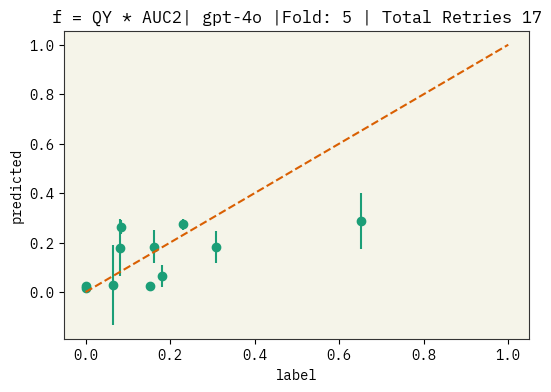

100%|██████████| 5/5 [15:13<00:00, 182.79s/it]

Run 0: 0.11 +/- 0.00
Run 1: 0.19 +/- 0.00
Run 2: 0.16 +/- 0.00
Run 3: 0.15 +/- 0.00
Run 4: 0.14 +/- 0.00


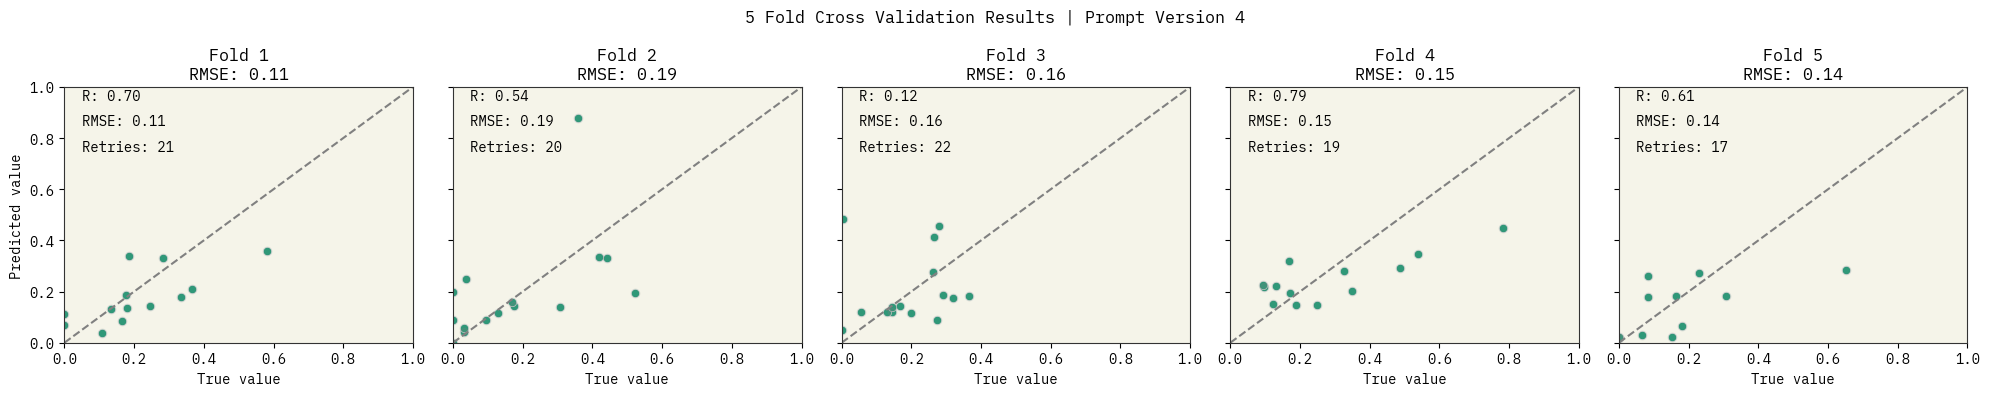

In [ ]:
yhat_4_gpt4,std_hat_4_gpt4,y_4_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=4)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488:

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Fold 0 done
|        predicted        |   label    |     AE     | 
|    0.15    |    0.14    |    0.01    |
|    0.22    |    0.28    |    0.06    |
|    0.08    |    0.10    |    0.02    |
|    0.11    |    0.09    |    0.02    |
|    0.12    |    0.09    |    0.02    |
|    0.16    |    0.00    |    0.16    |
|    0.13    |    0.17    |    0.04    |
|    0.27    |    0.33    |    0.06    |
|    0.25    |    0.03    |    0.22    |
|    0.15    |    0.06    |    0.10    |
|    0.31    |    0.35    |    0.04    |
|    0.32    |    0.36    |    0.04    |
|    0.07    |    0.17    |    0.10    |
|    0.06    |    0.00    |    0.06    |
|    0.24    |    0.19    |    0.06    |

              RMSE: 0.09              


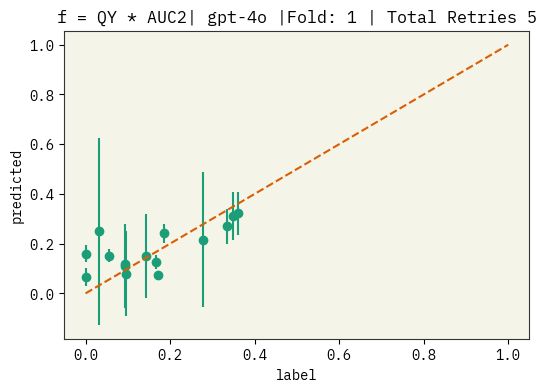

 20%|██        | 1/5 [01:42<06:48, 102.02s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktel

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 1 done
|        predicted        |   label    |     AE     | 
|    0.11    |    0.11    |    0.00    |
|    0.32    |    0.28    |    0.04    |
|    0.22    |    0.54    |    0.32    |
|    0.18    |    0.13    |    0.05    |
|    0.29    |    0.33    |    0.04    |
|    0.13    |    0.18    |    0.05    |
|    0.08    |    0.09    |    0.01    |
|    0.88    |    0.27    |    0.61    |
|    0.34    |    0.65    |    0.31    |
|    0.31    |    0.42    |    0.11    |
|    0.15    |    0.04    |    0.12    |
|    0.15    |    0.20    |    0.05    |
|    0.14    |    0.37    |    0.22    |
|    0.11    |    0.27    |    0.17    |
|    0.17    |    0.14    |    0.03    |

              RMSE: 0.21              


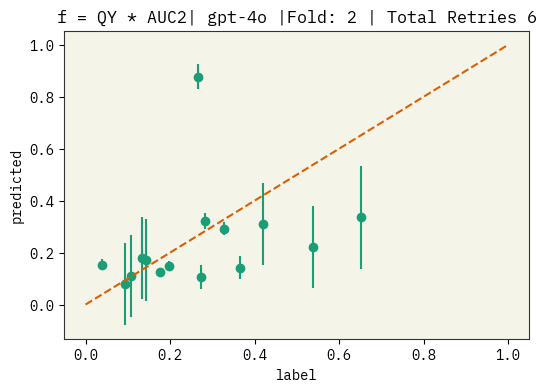

 40%|████      | 2/5 [03:09<04:40, 93.53s/it] /Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 2 done
|        predicted        |   label    |     AE     | 
|    0.13    |    0.17    |    0.03    |
|    0.00    |    0.18    |    0.18    |
|    0.16    |    0.13    |    0.03    |
|    0.11    |    0.12    |    0.02    |
|    0.50    |    0.00    |    0.50    |
|    0.41    |    0.32    |    0.09    |
|    0.47    |    0.78    |    0.31    |
|    0.16    |    0.23    |    0.08    |
|    0.03    |    0.15    |    0.12    |
|    0.09    |    0.12    |    0.03    |
|    0.02    |    0.00    |    0.02    |
|    0.29    |    0.29    |    0.00    |
|    0.05    |    0.17    |    0.12    |
|    0.01    |    0.16    |    0.15    |
|    0.02    |    0.00    |    0.02    |

              RMSE: 0.17              


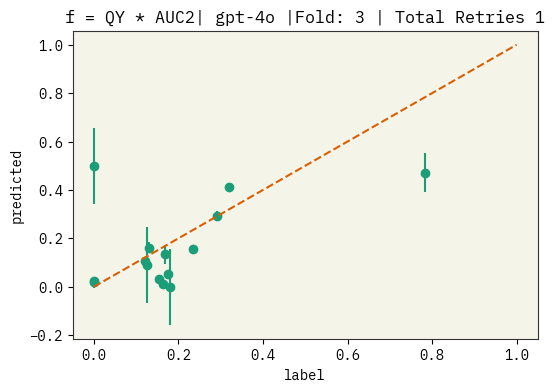

 60%|██████    | 3/5 [04:04<02:32, 76.03s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 3 done
|        predicted        |   label    |     AE     | 
|    0.12    |    0.06    |    0.06    |
|    0.11    |    0.09    |    0.01    |
|    0.10    |    0.17    |    0.07    |
|    0.31    |    0.36    |    0.06    |
|    0.08    |    0.00    |    0.08    |
|    0.16    |    0.00    |    0.16    |
|    0.11    |    0.52    |    0.41    |
|    0.10    |    0.13    |    0.03    |
|    0.24    |    0.44    |    0.20    |
|    0.49    |    0.31    |    0.19    |
|    0.11    |    0.10    |    0.01    |
|    0.14    |    0.13    |    0.01    |
|    0.17    |    0.31    |    0.14    |
|    0.21    |    0.25    |    0.04    |
|    0.01    |    0.03    |    0.03    |

              RMSE: 0.14              


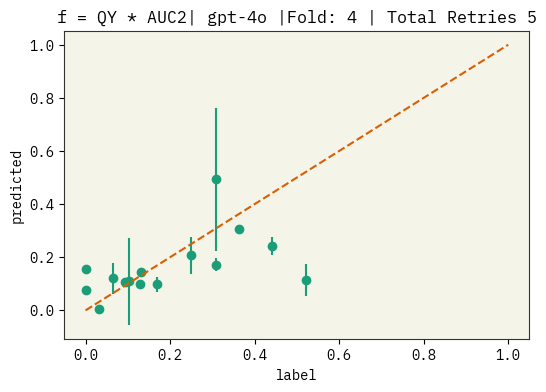

 80%|████████  | 4/5 [05:48<01:26, 86.85s/it]/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")


Prediction is greater than 1, retrying


/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/jorgemedina/miniforge3/envs/new_bolift/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provi

Fold 4 done
|        predicted        |   label    |     AE     | 
|    0.35    |    0.08    |    0.27    |
|    0.07    |    0.25    |    0.17    |
|    0.08    |    0.10    |    0.02    |
|    0.31    |    0.00    |    0.31    |
|    0.19    |    0.17    |    0.02    |
|    0.25    |    0.26    |    0.01    |
|    0.09    |    0.10    |    0.01    |
|    0.19    |    0.18    |    0.01    |
|    0.47    |    0.58    |    0.12    |
|    0.01    |    0.00    |    0.01    |
|    0.32    |    0.49    |    0.16    |
|    0.22    |    0.23    |    0.01    |
|    0.15    |    0.19    |    0.03    |
|    0.04    |    0.08    |    0.05    |

              RMSE: 0.13              


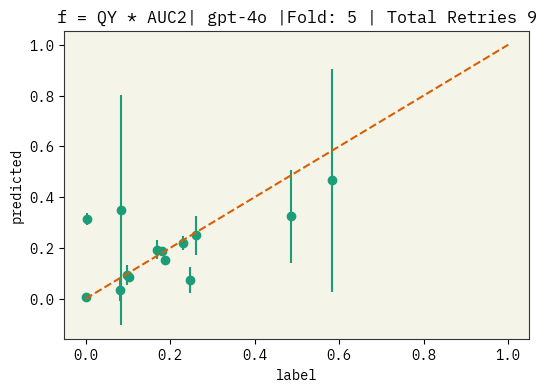

100%|██████████| 5/5 [07:52<00:00, 94.43s/it] 

Run 0: 0.09 +/- 0.00
Run 1: 0.21 +/- 0.00
Run 2: 0.17 +/- 0.00
Run 3: 0.14 +/- 0.00


Run 4: 0.13 +/- 0.00


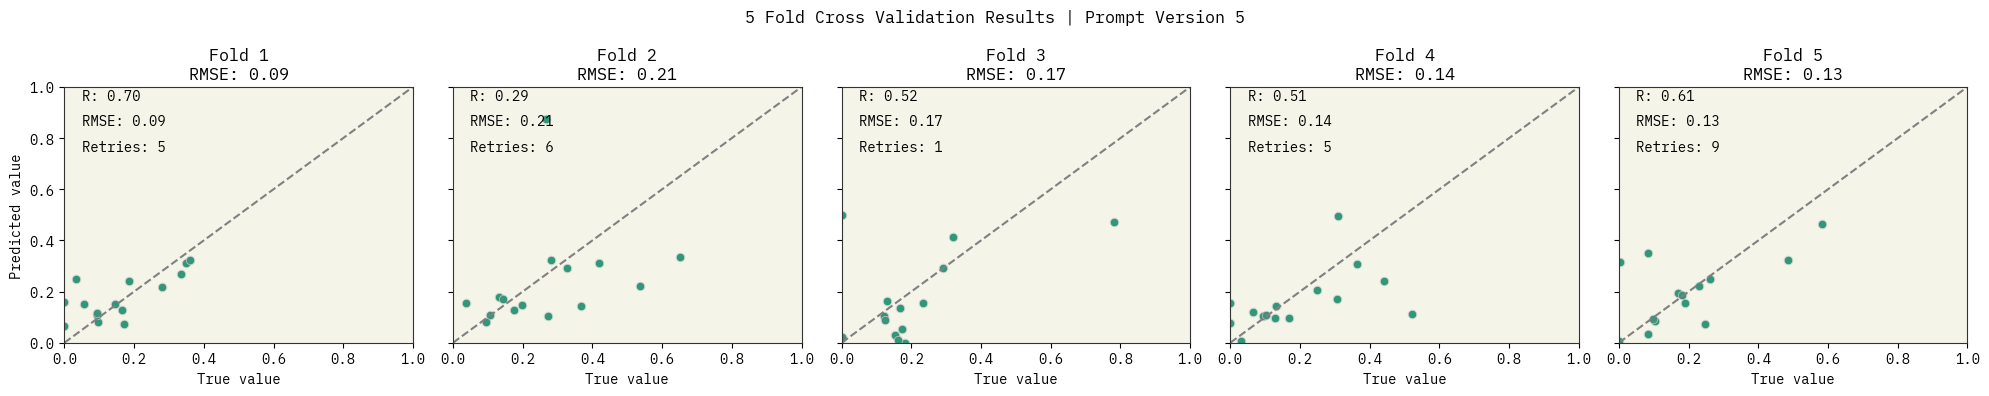

In [ ]:
yhat_5_gpt4,std_hat_5_gpt4,y_5_gpt4 = cv_asktell(df, model="gpt-4o", selector_k=5, temperature=0.7,prompt_version=5)

## Orginal Prompt used in Optimization Process

Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x <br> 
hexanes dilution of stock is {Dilution(%)}% recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is <br>
diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. Silver acetate solution of {AgConc(M)} M <br>
is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. <br>
{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. <br>
The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. Fluorescence of <br>
each doped sample was collected as a 30x dilution with hexanes.

Q: Given the experimental procedure: 
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x
hexanes dilution of stock is 0.175% recorded at 512 nm. 0.25 mL nanoplatelets stock is 
diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M 
is made with 3.5 mg of silver acetate in 20 mL of MeOH and 8 mL of water. 
1.5 % Ag doping requires 18.0 uL of silver doping solution, respectively. 
The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of 
each doped sample was collected as a 30x dilution with hexanes.
Knowing that: 1) an increase in silver doping will increase the fluorescence SECONDARY PEAK AREA, 
and 2) QUANTUM YIELD decreases as Ag doping increases, although some reports indicate that theres a slight increase before decreasing.
What is product of the quantum yield with the area under the fluorescence peak at 650 nm?
A: 0.04###

## New Prompt from Farwa's opinion 1

Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x 
hexanes dilution of stock is {Dilution(%)}% recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is 
diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. Silver acetate solution of {AgConc(M)} M 
is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. 
{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. 
The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. Fluorescence of 
each doped sample was collected as a 30x dilution with hexanes.
Knowing that: 1) an increase in silver doping will increase the fluorescence SECONDARY PEAK AREA, 
and 2) QUANTUM YIELD decreases as Ag doping increases, although some reports indicate that theres a slight increase before decreasing.
What is product of the quantum yield with the area under the fluorescence peak at 650 nm? 

## New Prompt from Farwa's opinion 2

Stock nanoplatelets (NPL) have dimensions {Dimension1(nm)} nm by {Dimension2(nm)}, which gives a total Cd count per NPL as {(Dimension1(nm)*Dimension2(nm)*8.8968*4)/0.221448125} 
nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% recorded at 512nm, resulting in a theoretical NPL concentration of {31900000/Dilution(%)} M.  {Nano_stock_vol(mL)} mL nanoplatelets stock is  diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. Silver acetate solution of {AgConc(M)} M 
is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. 
{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. 
The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. Fluorescence of 
each doped sample was collected as a 30x dilution with hexanes.
What is product of the quantum yield with the area under the fluorescence peak at 650 nm? 

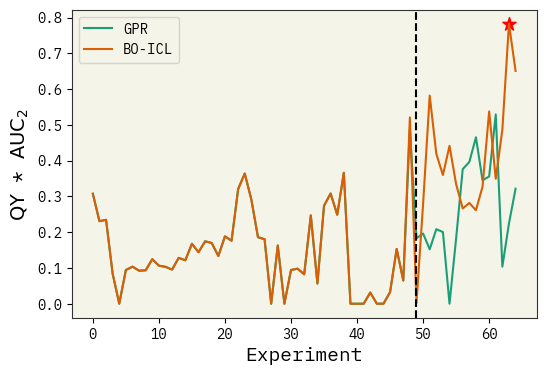

In [12]:
#get the data from /Users/jorgemedina/BioNano-DOE/AgML/Data/modified_featuresforBO_corrected_onlyJ.csv and /Users/jorgemedina/BioNano-DOE/AgML/Data/modified_featuresforBO_corrected_onlyM.csv
# and plot the label values (last column), add a vertical line at the 49th point 

df_J = pd.read_csv('/Users/jorgemedina/BioNano-DOE/AgML/Data/modified_featuresforBO_corrected_onlyJ.csv')
df_M = pd.read_csv('/Users/jorgemedina/BioNano-DOE/AgML/Data/modified_featuresforBO_corrected_onlyM.csv')

plt.figure(figsize=(6, 4))
#title: Optimization run BO-LIFT and GPR
plt.ylabel(r'${\rm QY}$ * ${\rm AUC_2}$', fontsize=14)
plt.xlabel('Experiment', fontsize=14)
plt.plot(df_J['label'], label='GPR')
plt.plot(df_M['label'], label='BO-ICL')
plt.axvline(x=49, color='k', linestyle='--')
plt.legend()
#put a small star at the second to last point for the BO-lIFT
plt.scatter(63, df_M['label'][63], marker='*', s=100, c='r')
plt.show()